### 0. Import Packages

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import sklearn.tree as tree
import folium
import warnings
import glob
import random

from pycaret.regression import *
from matplotlib import pyplot as plt
from collections import Counter
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import * 
from sklearn.linear_model import *
from scipy import stats
from statsmodels.tools.tools import add_constant

### 1. Read Files

In [2]:
warnings.filterwarnings('ignore')

#set seed
np.random.seed(1234)

df = pd.DataFrame()

#load data   https://www.kaggle.com/datasets/nishiodens/japan-real-estate-transaction-prices
#takes in housing data in the latest 5 years (2015-2019)

for f in glob.glob("./trade_prices/*.csv"):
    temp = pd.read_csv(f)
    df = df.append(
        temp.loc[(temp["Year"] > 2014) 
                 #& (temp["Use"] == "House") 
                 #& (temp["Purpose"] == "House")
                 ,:])

### 2. Data Cleaning Part 1

In [3]:
# clean up prefecture column
df["Prefecture"] = df["Prefecture"].str.replace(" Prefecture", "")

# use data from only the Tokyo Metropolitan Employment Area
prefs = ["Chiba", "Saitama", "Tokyo", "Kanagawa"]
data = df[df['Prefecture'].isin(prefs)]

In [4]:
#load pop data https://www.kaggle.com/datasets/jd1325/japan-population-data
pop_data = pd.read_csv("./Japan_population_data.csv")
pop_data = pop_data.loc[pop_data["year"] == pop_data.groupby("prefecture")["year"].max().unique()[0], :]

In [5]:
# clean up prefecture column
pop_data["Prefecture"] = pop_data["prefecture"].apply(lambda x: x.split('-')[0])
pop_data.shape

(47, 8)

In [6]:
data = pd.merge(data, pop_data, on = ["Prefecture"])
data = data.drop(['prefecture', 'year', 'capital', 'region', 'island'], axis = 1)

In [7]:
data.shape

(390850, 40)

### 3. Exploratory Data Analysis

#### 3.1 Spread of TradePrice

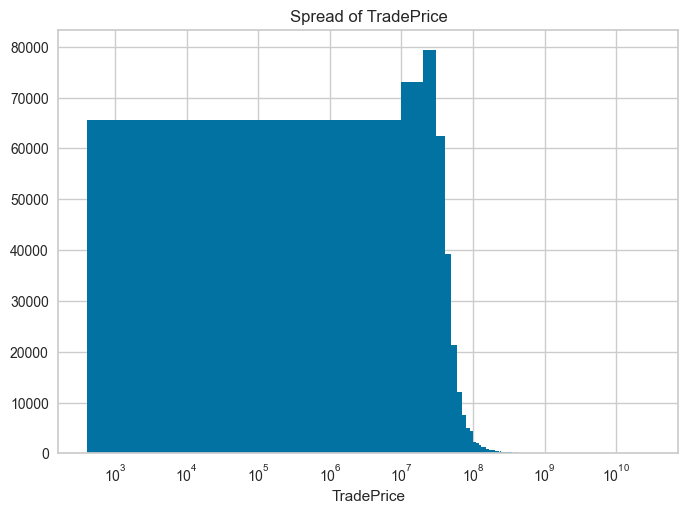

In [8]:
data['TradePrice'].hist(bins = 3000)
plt.title("Spread of TradePrice")
plt.xscale("log")
plt.xlabel("TradePrice")
plt.show()

#### 3.2 Description of Data

In [9]:
data.describe() #continuous

No  MunicipalityCode  MinTimeToNearestStation  \
count  390850.000000     390850.000000            382718.000000   
mean   115115.855095      12848.387297                15.005388   
std     89604.829225       1029.817896                13.630222   
min         1.000000      11101.000000                 0.000000   
25%     40050.250000      12204.000000                 7.000000   
50%     99932.500000      13112.000000                11.000000   
75%    164662.750000      13361.000000                19.000000   
max    360144.000000      14402.000000               120.000000   

       MaxTimeToNearestStation    TradePrice           Area  \
count            381107.000000  3.908500e+05  390850.000000   
mean                 17.946750  4.536189e+07     197.417692   
std                  19.665787  1.702467e+08     382.529630   
min                   0.000000  4.000000e+02      10.000000   
25%                   7.000000  1.500000e+07      65.000000   
50%                  11.000000  2.800000e+07     105.000000   
75%                  19.000000  4.300000e+07     170.000000   
max                 120.000000  3.000000e+10    5000.000000   

       AreaIsGreaterFlag     UnitPrice  PricePerTsubo       Frontage  ...  \
count      390850.000000  9.302700e+04   9.302700e+04  230737.000000  ...   
mean            0.009971  2.085443e+05   6.892913e+05      11.660975  ...   
std             0.099354  3.023799e+05   9.984463e+05       8.037131  ...   
min             0.000000  1.000000e+00   3.000000e+00       0.500000  ...   
25%             0.000000  4.800000e+04   1.600000e+05       7.000000  ...   
50%             0.000000  1.300000e+05   4.300000e+05      10.000000  ...   
75%             0.000000  2.600000e+05   8.600000e+05      13.500000  ...   
max             1.000000  1.400000e+07   4.500000e+07      50.000000  ...   

       TotalFloorAreaIsGreaterFlag   BuildingYear  PrewarBuilding  \
count                390850.000000  278256.000000   390850.000000   
mean                      0.002241    1999.740875        0.000463   
std                       0.047289      15.469763        0.021515   
min                       0.000000    1945.000000        0.000000   
25%                       0.000000    1988.000000        0.000000   
50%                       0.000000    2002.000000        0.000000   
75%                       0.000000    2015.000000        0.000000   
max                       1.000000    2020.000000        1.000000   

             Breadth  CoverageRatio  FloorAreaRatio           Year  \
count  249328.000000  374121.000000   374121.000000  390850.000000   
mean        6.135118      60.396503      218.878999    2016.784969   
std         4.054171      10.994150      129.621157       1.332725   
min         1.000000      30.000000       50.000000    2015.000000   
25%         4.000000      60.000000      150.000000    2016.000000   
50%         5.000000      60.000000      200.000000    2017.000000   
75%         6.000000      60.000000      200.000000    2018.000000   
max        96.000000      80.000000     1300.000000    2019.000000   

             Quarter    population  estimated_area  
count  390850.000000  3.908500e+05   390850.000000  
mean        2.407865  9.897889e+06     3088.609423  
std         1.110248  2.972790e+06     1129.861280  
min         1.000000  6.224027e+06     2188.670000  
25%         1.000000  7.261271e+06     2188.670000  
50%         2.000000  9.127323e+06     2415.860000  
75%         3.000000  1.351373e+07     3798.080000  
max         4.000000  1.351373e+07     5156.610000  

[8 rows x 21 columns]

In [10]:
data.describe(include = 'object') #categorical

Type            Region Prefecture  \
count                                390850            254341     390850   
unique                                    5                 4          4   
top     Residential Land(Land and Building)  Residential Area      Tokyo   
freq                                 161314            232376     147273   

         Municipality DistrictName NearestStation TimeToNearestStation  \
count          390850       390847         383003               382718   
unique            248         7201           1496                   34   
top     Setagaya Ward       Honcho     Hon-atsugi         30-60minutes   
freq             9131         2394           2345                34224   

       FloorPlan                LandShape Structure     Use Purpose Direction  \
count     123892                   254206    277487  259435  331937    254339   
unique        43                        9        23     186       6         9   
top         3LDK  Semi-rectangular Shaped         W   House   House     South   
freq       47852                    87981    128743  229950  291540     35606   

       Classification                                       CityPlanning  \
count          251268                                             380960   
unique             14                                                 16   
top         City Road  Category I Exclusively Low-story Residential Zone   
freq           144194                                              96677   

                  Period Renovation                          Remarks  
count             390850     113932                            21704  
unique                19          2                               20  
top     1st quarter 2015    Not yet  Dealings including private road  
freq               22335      81129                            15348

#### 3.3 Distribution of Data Points

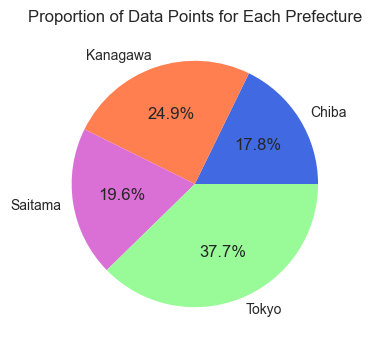

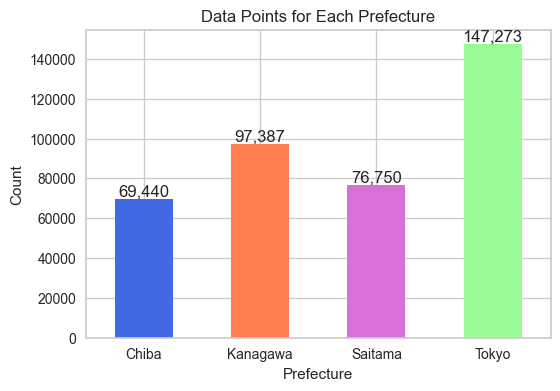

In [11]:
colors = ['royalblue', 'coral', 'orchid', 'palegreen']

plt.figure(figsize = (6,4))
data.groupby("Prefecture")["Prefecture"].count().plot.pie(autopct='%1.1f%%',colors=colors)
plt.title("Proportion of Data Points for Each Prefecture")
plt.ylabel("")
plt.show()

plt.figure(figsize=(6, 4))

ax = data.groupby("Prefecture")["Prefecture"].count().plot.bar(color=colors)

for i, v in enumerate(data.groupby("Prefecture")["Prefecture"].count()):
    label = '{:,.0f}'.format(v)
    ax.text(i, v, '{:,}'.format(v), ha='center', va='bottom')

plt.xticks(rotation=0)
plt.title("Data Points for Each Prefecture")
plt.xlabel("Prefecture")
plt.ylabel("Count")
plt.show()

#### 3.4 Population Data

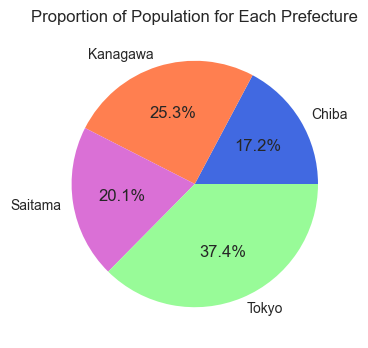

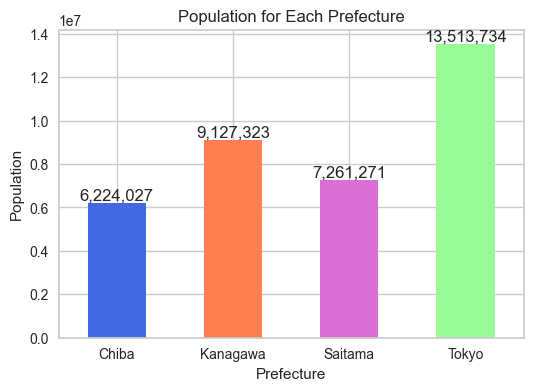

In [12]:
plt.figure(figsize = (6,4))
data.groupby("Prefecture")["population"].mean().plot.pie(autopct='%1.1f%%',colors=colors)
plt.title("Proportion of Population for Each Prefecture")
plt.ylabel("")
plt.show()

plt.figure(figsize=(6, 4))

ax = data.groupby("Prefecture").median("population")["population"].plot.bar(color=colors)

for i, v in enumerate(data.groupby("Prefecture").median("population")["population"]):
    label = '{:,.0f}'.format(v)
    ax.text(i, v, label, ha='center', va='bottom')

plt.xticks(rotation=0)
plt.title("Population for Each Prefecture")
plt.xlabel("Prefecture")
plt.ylabel("Population")
plt.show()

#### 3.5 TradePrice

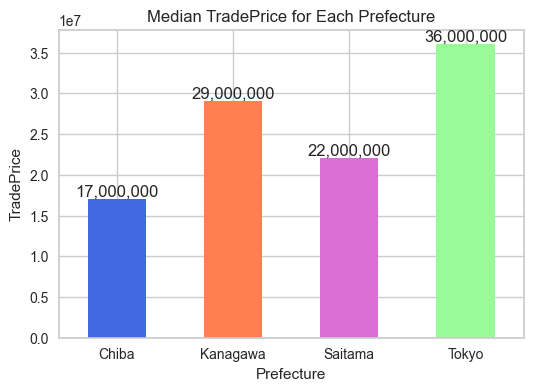

In [13]:
plt.figure(figsize=(6, 4))

ax = data.groupby("Prefecture").median("TradePrice")["TradePrice"].plot.bar(color=colors)

for i, v in enumerate(data.groupby("Prefecture").median("TradePrice")["TradePrice"]):
    label = '{:,.0f}'.format(v)
    ax.text(i, v, label, ha='center', va='bottom')

plt.xticks(rotation=0)
plt.title("Median TradePrice for Each Prefecture")
plt.xlabel("Prefecture")
plt.ylabel("TradePrice")
plt.show()

In [14]:
data_map = data[data['Prefecture'].isin(prefs)]

avg_prices = pd.DataFrame(round(data_map.groupby('Prefecture')['TradePrice'].median()))
avg_prices["prefecture"]=avg_prices.index
avg_prices.rename(columns={"TradePrice":"MedianTradePrice"},inplace=True)

jps = gpd.read_file("japan_prefectures.geojson")
pref = pd.read_json("japan_prefectures.geojson")

for i in range(len(pref)):
    jps.loc[i,"prefecture"] = pref.loc[i]["features"]["id"]
merged = pd.merge(jps,avg_prices,on='prefecture')

f = folium.Figure(width=900, height=600)

m = merged.explore(
     column="MedianTradePrice",
     cmap = 'bwr',
     scheme="Quantiles",
     legend=True,
     k=4,
     legend_kwds={'colorbar':True,
                  'scale':False},
     tooltip = ("prefecture","MedianTradePrice"),
     zoom_start=9, 
     location = (35.6,139.8),
     map_kwds = {'scrollWheelZoom':False,
                 'dragging':True}).add_to(f)
f

#### 3.5 Median Area

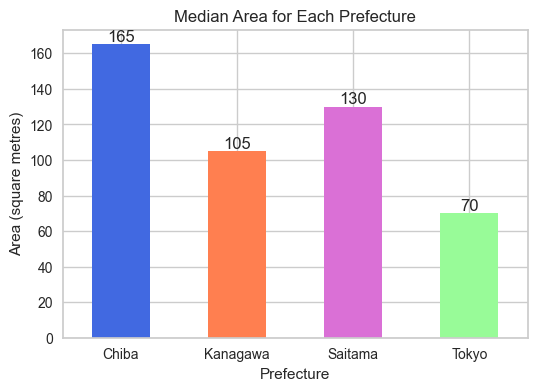

In [15]:
plt.figure(figsize = (6,4))

ax = data.groupby("Prefecture").median("Area")["Area"].plot.bar(color=colors)

for i, v in enumerate(data.groupby("Prefecture").median("Area")["Area"]):
    label = '{:.0f}'.format(v)
    ax.text(i, v, label, ha='center', va='bottom')

plt.xticks(rotation = 0)
plt.title("Median Area for Each Prefecture")
plt.xlabel("Prefecture")
plt.ylabel("Area (square metres)")
plt.show()

#### 3.6 Median Total Floor Area

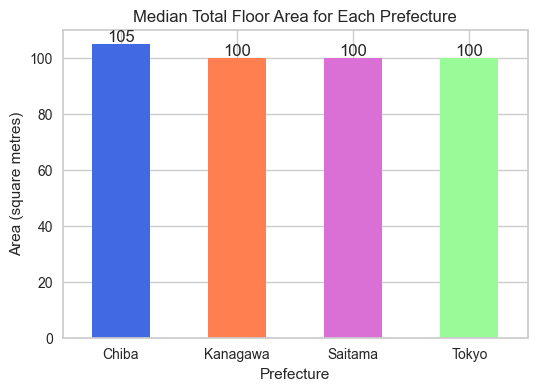

In [16]:
plt.figure(figsize = (6,4))

ax = data.groupby("Prefecture").median("TotalFloorArea")["TotalFloorArea"].plot.bar(color=colors)

for i, v in enumerate(data.groupby("Prefecture").median("TotalFloorArea")["TotalFloorArea"]):
    label = '{:.0f}'.format(v)
    ax.text(i, v, label, ha='center', va='bottom')

plt.xticks(rotation = 0)
plt.title("Median Total Floor Area for Each Prefecture")
plt.xlabel("Prefecture")
plt.ylabel("Area (square metres)")
plt.show()

#### 3.7 CityPlanning Category

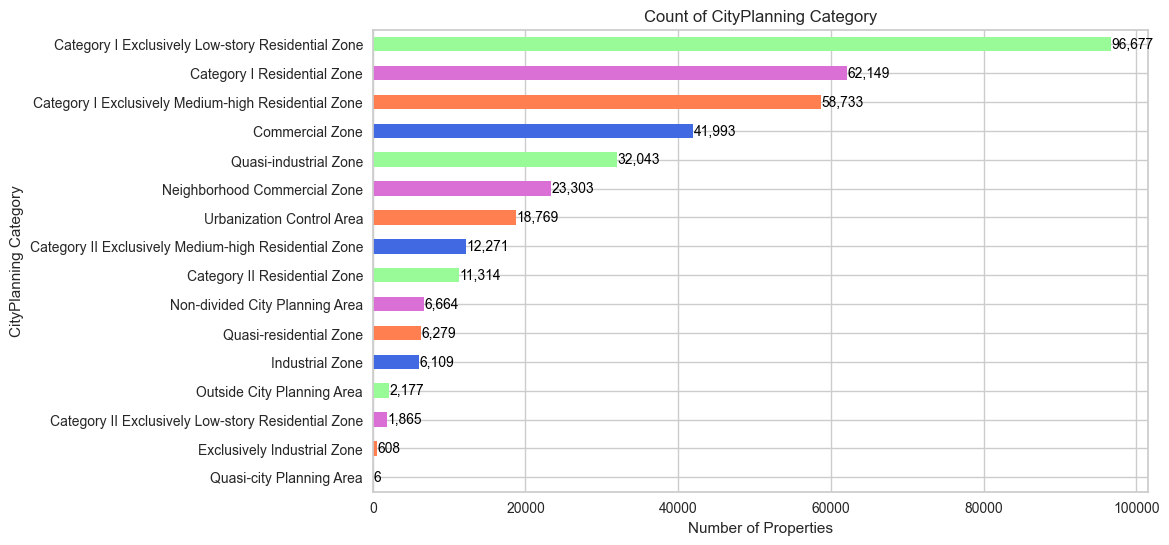

In [17]:
plt.figure(figsize=(10, 6))
ax = (data.groupby("CityPlanning")["CityPlanning"].count()).sort_values(ascending=True).plot.barh(color=colors)

for i, v in enumerate((data.groupby("CityPlanning")["CityPlanning"].count()).sort_values(ascending=True)):
    label = '{:,.0f}'.format(v)
    ax.text(v + 50, i, label, color='black', fontsize=10, ha='left', va='center')

plt.xticks(rotation=00)
plt.title("Count of CityPlanning Category")
plt.xlabel("Number of Properties")
plt.ylabel("CityPlanning Category")
plt.show()

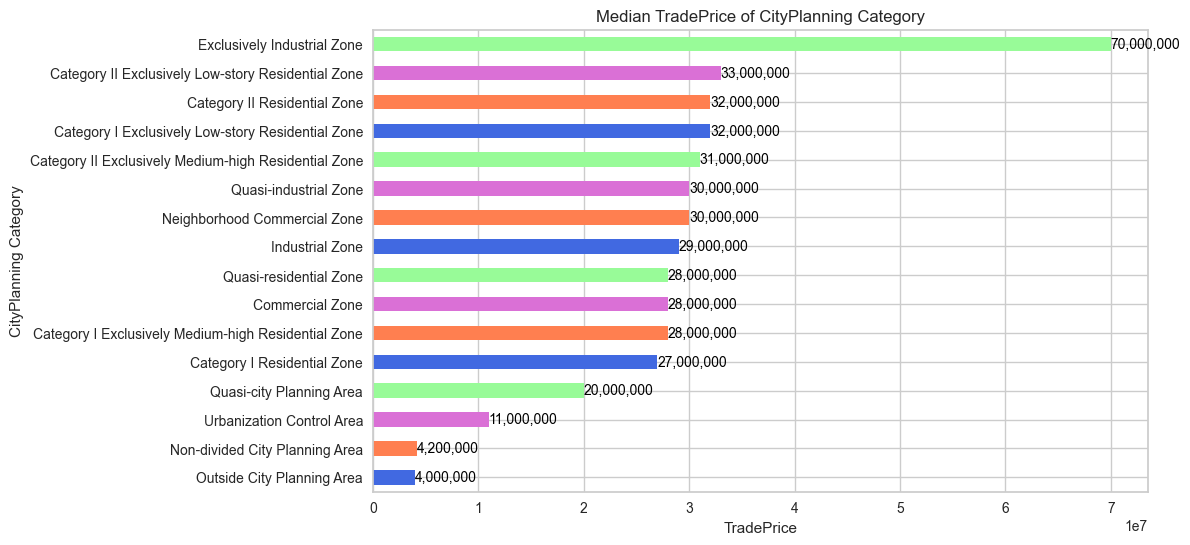

In [18]:
#city planning vs tradeprice

plt.figure(figsize=(10, 6))
ax = (data.groupby("CityPlanning").median("TradePrice")["TradePrice"]).sort_values(ascending=True).plot.barh(color=colors)

for i, v in enumerate((data.groupby("CityPlanning").median("TradePrice")["TradePrice"]).sort_values(ascending=True)):
    label = '{:,.0f}'.format(v)
    ax.text(v + 50, i, label, color='black', fontsize=10, ha='left', va='center')

plt.xticks(rotation=00)
plt.title("Median TradePrice of CityPlanning Category")
plt.xlabel("TradePrice")
plt.ylabel("CityPlanning Category")
plt.show()

#### 3.8 Road Direction

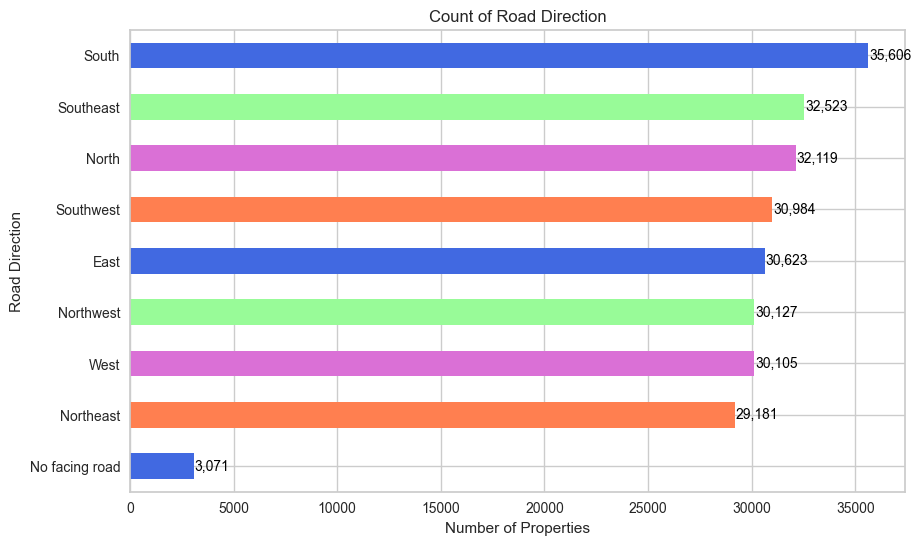

In [19]:
plt.figure(figsize=(10, 6))
ax = (data.groupby("Direction")["Direction"].count()).sort_values(ascending=True).plot.barh(color=colors)

for i, v in enumerate((data.groupby("Direction")["Direction"].count()).sort_values(ascending=True)):
    label = '{:,.0f}'.format(v)
    ax.text(v + 50, i, label, color='black', fontsize=10, ha='left', va='center')

plt.xticks(rotation=00)
plt.title("Count of Road Direction")
plt.xlabel("Number of Properties")
plt.ylabel("Road Direction")
plt.show()

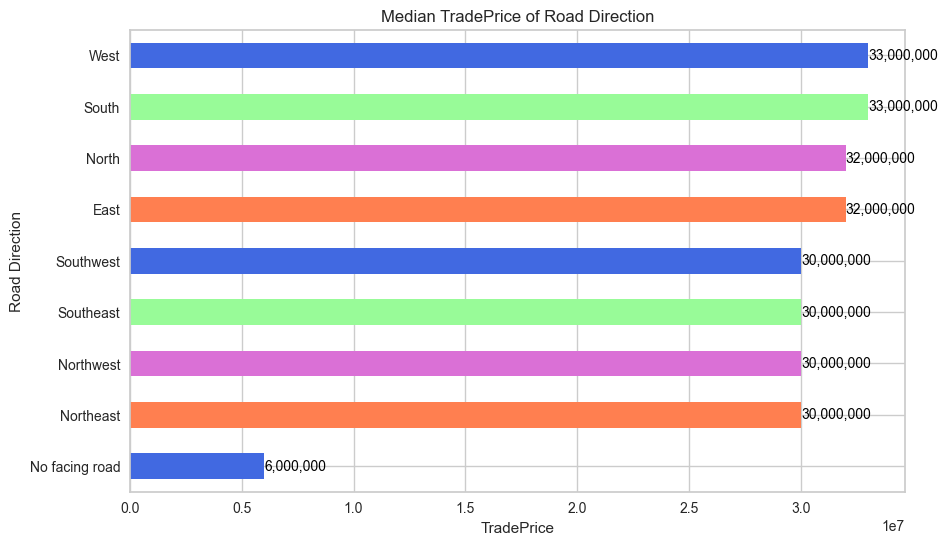

In [20]:
plt.figure(figsize=(10, 6))
ax = (data.groupby("Direction").median("TradePrice")["TradePrice"]).sort_values(ascending=True).plot.barh(color=colors)

for i, v in enumerate((data.groupby("Direction").median("TradePrice")["TradePrice"]).sort_values(ascending=True)):
    label = '{:,.0f}'.format(v)
    ax.text(v + 50, i, label, color='black', fontsize=10, ha='left', va='center')

plt.xticks(rotation=00)
plt.title("Median TradePrice of Road Direction")
plt.xlabel("TradePrice")
plt.ylabel("Road Direction")
plt.show()

#### 3.9 Coverage Ratio

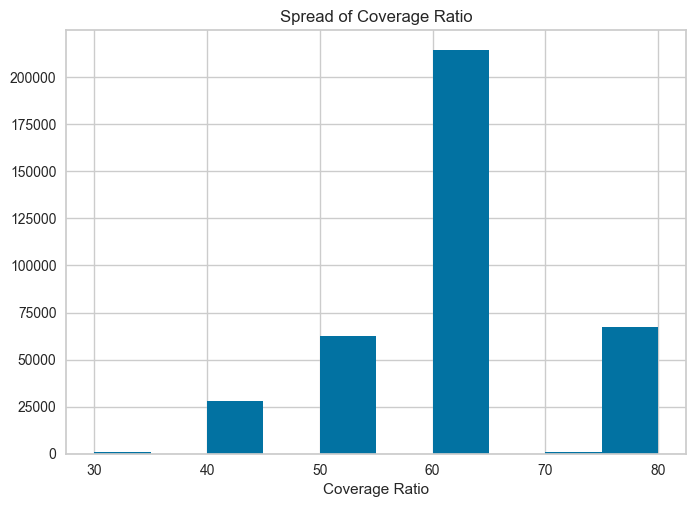

In [21]:
data['CoverageRatio'].hist(bins = 10)
plt.title("Spread of Coverage Ratio")
plt.xlabel("Coverage Ratio")
plt.show()

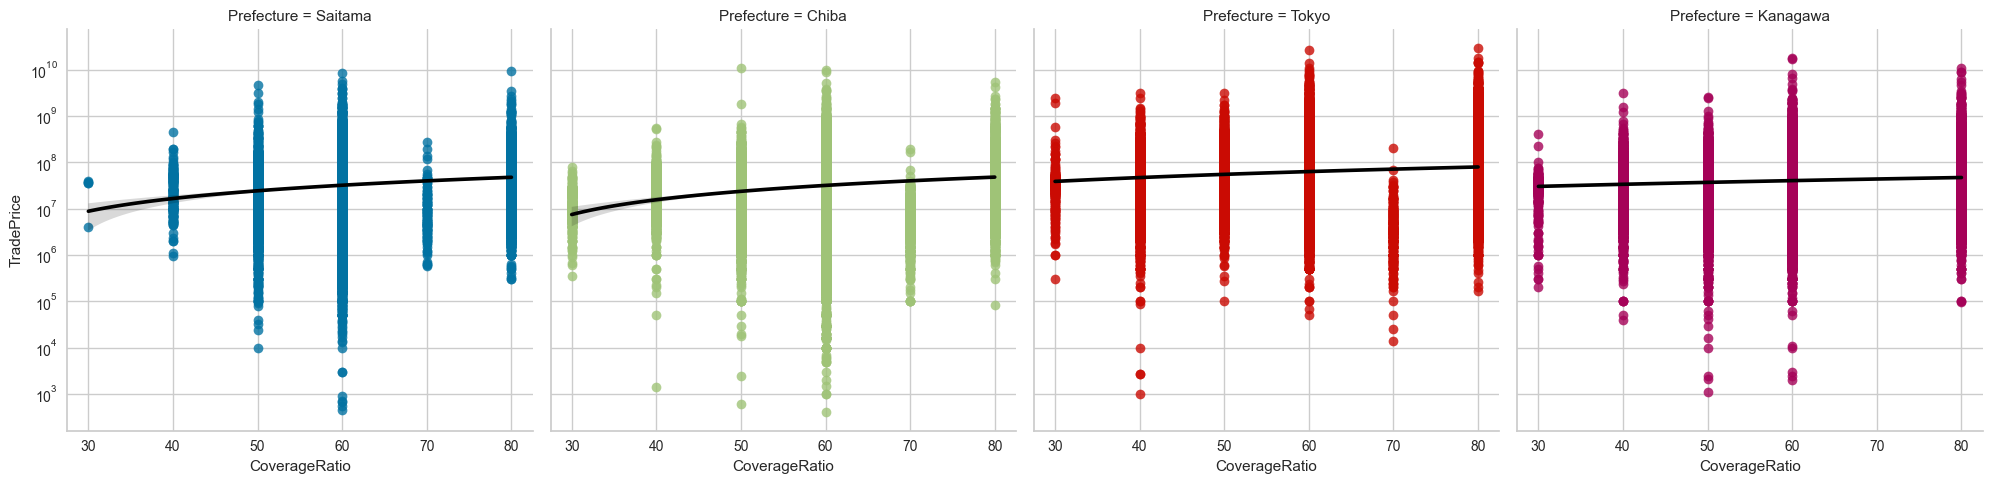

In [22]:
#coverage ratio vs tradeprice
g = sns.lmplot(x="CoverageRatio", y="TradePrice", data=data, hue='Prefecture', col="Prefecture", line_kws={'color': 'black', 'label': 'Best Fit Line'})
g.set(yscale="log")
plt.show()

#### 3.10 Correlation

##### 3.10.1 Area vs TradePrice

Best-Fit Line: -205181.34715025913x + 50108808.290155455


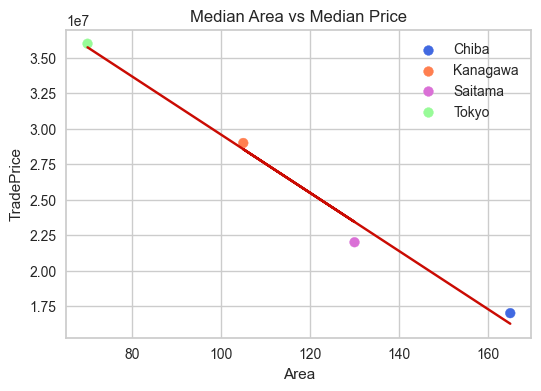

In [23]:
areaprice = pd.concat((data.groupby("Prefecture").median("Area")["Area"], data.groupby("Prefecture").median("TradePrice")["TradePrice"]), axis = 1)
bestfit = np.polyfit(areaprice["Area"], areaprice["TradePrice"], 1)
print("Best-Fit Line: {}x + {}".format(bestfit[0], bestfit[1]))
bestfit = bestfit[1] + bestfit[0] * areaprice["Area"]

plt.figure(figsize = (6,4))
plt.scatter(areaprice["Area"], areaprice["TradePrice"],c=colors)
for i in range(len(colors)):
    plt.scatter([], [], c=colors[i], label=areaprice.index[i])
plt.legend()
plt.plot(areaprice["Area"], bestfit, 'r')
plt.title("Median Area vs Median Price")
plt.xlabel("Area")
plt.ylabel("TradePrice")
plt.show()

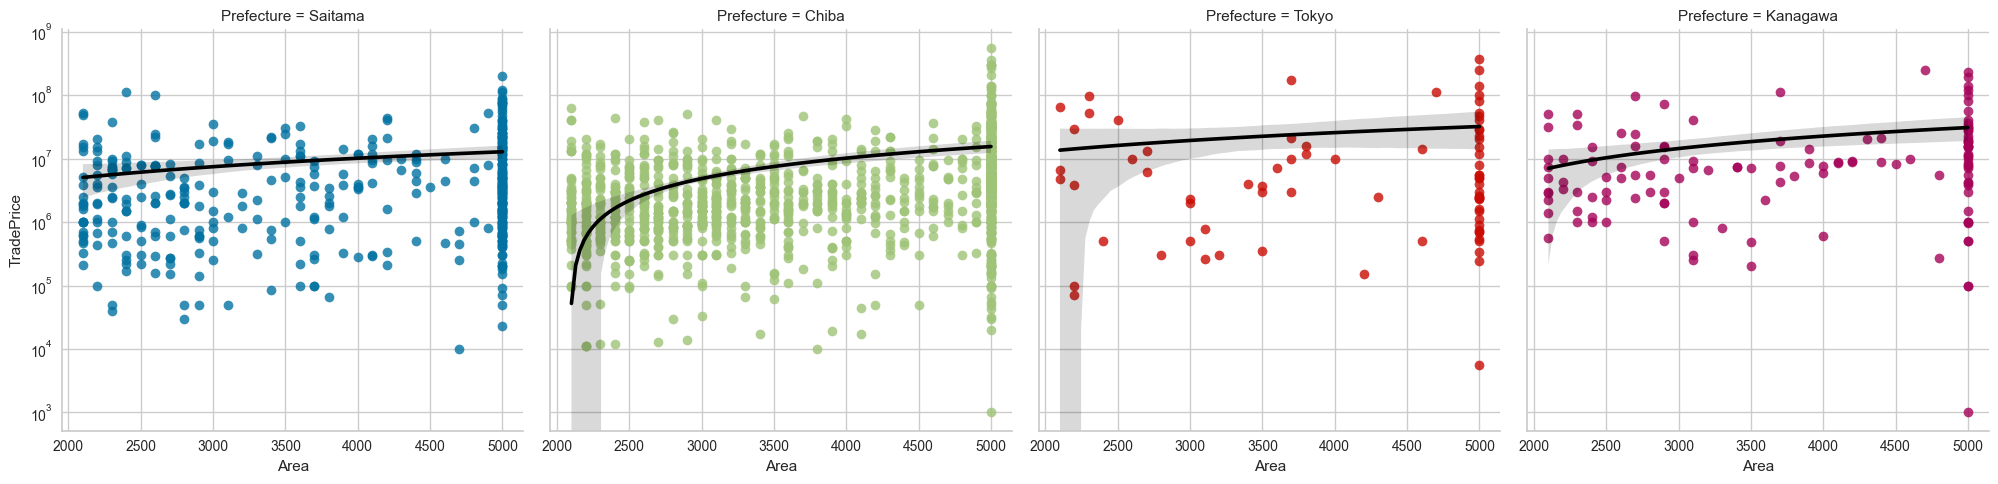

In [24]:
g = sns.lmplot(x="Area", y="TradePrice", data=data.loc[data['Area']>2000], hue='Prefecture', col="Prefecture", line_kws={'color': 'black', 'label': 'Best Fit Line'})
g.set(yscale="log")
plt.show()

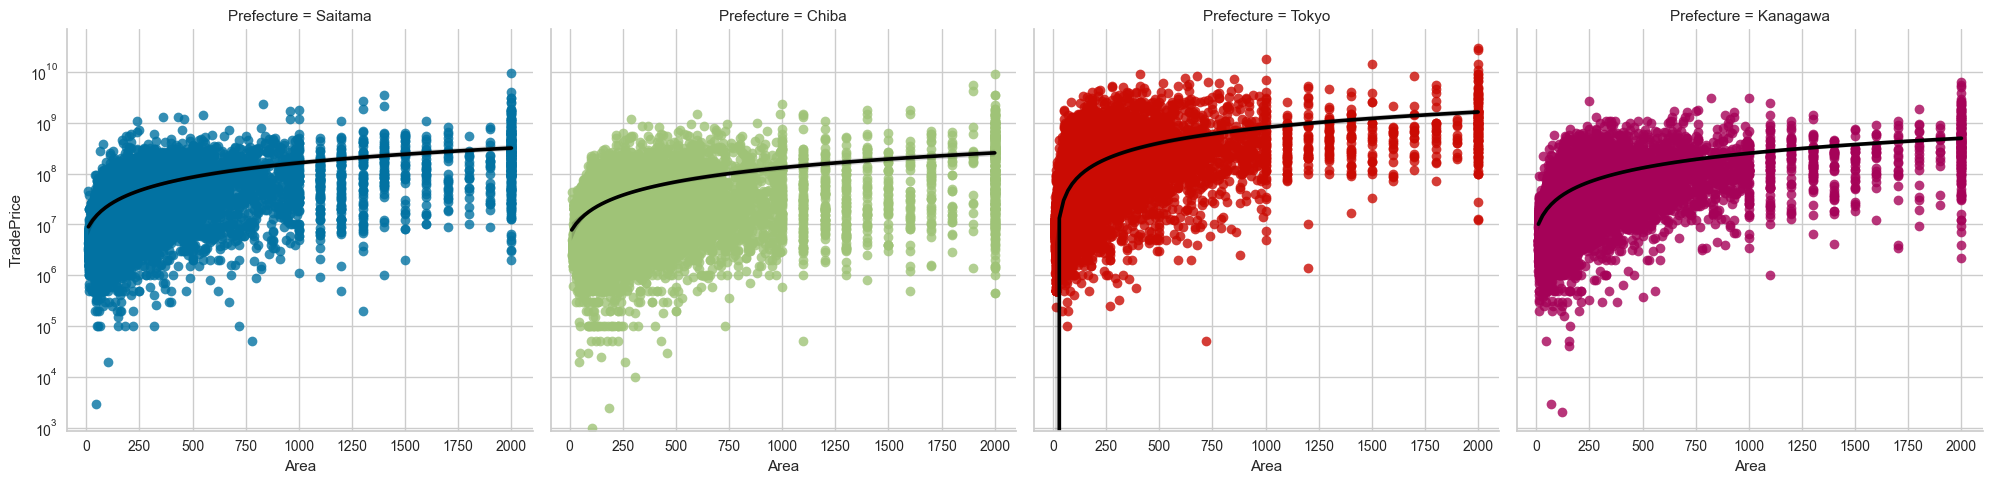

In [84]:
g = sns.lmplot(x="Area", y="TradePrice", data=data.loc[data['Area']<=2000], hue='Prefecture', col="Prefecture", line_kws={'color': 'black', 'label': 'Best Fit Line'})
g.set(yscale="log")
plt.show()

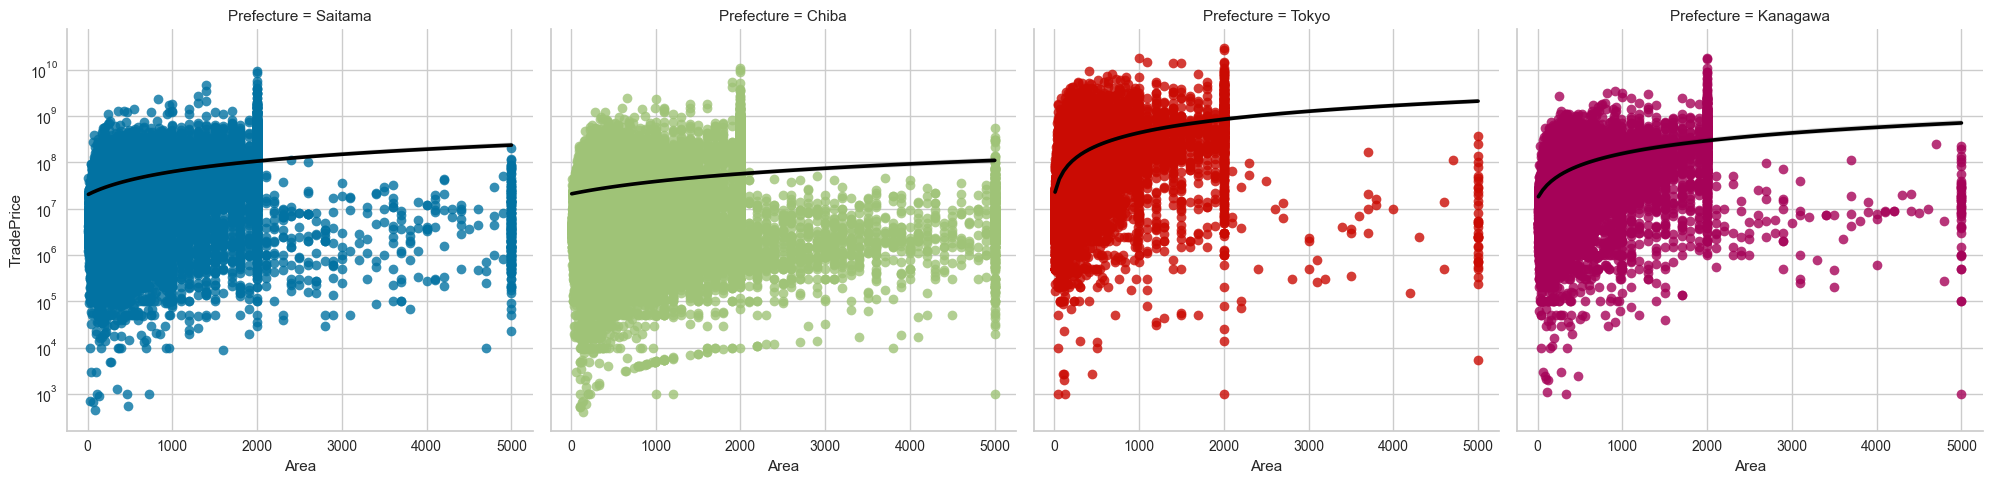

In [26]:
g = sns.lmplot(x="Area", y="TradePrice", data=data, hue='Prefecture', col="Prefecture", line_kws={'color': 'black', 'label': 'Best Fit Line'})
g.set(yscale="log")
plt.show()

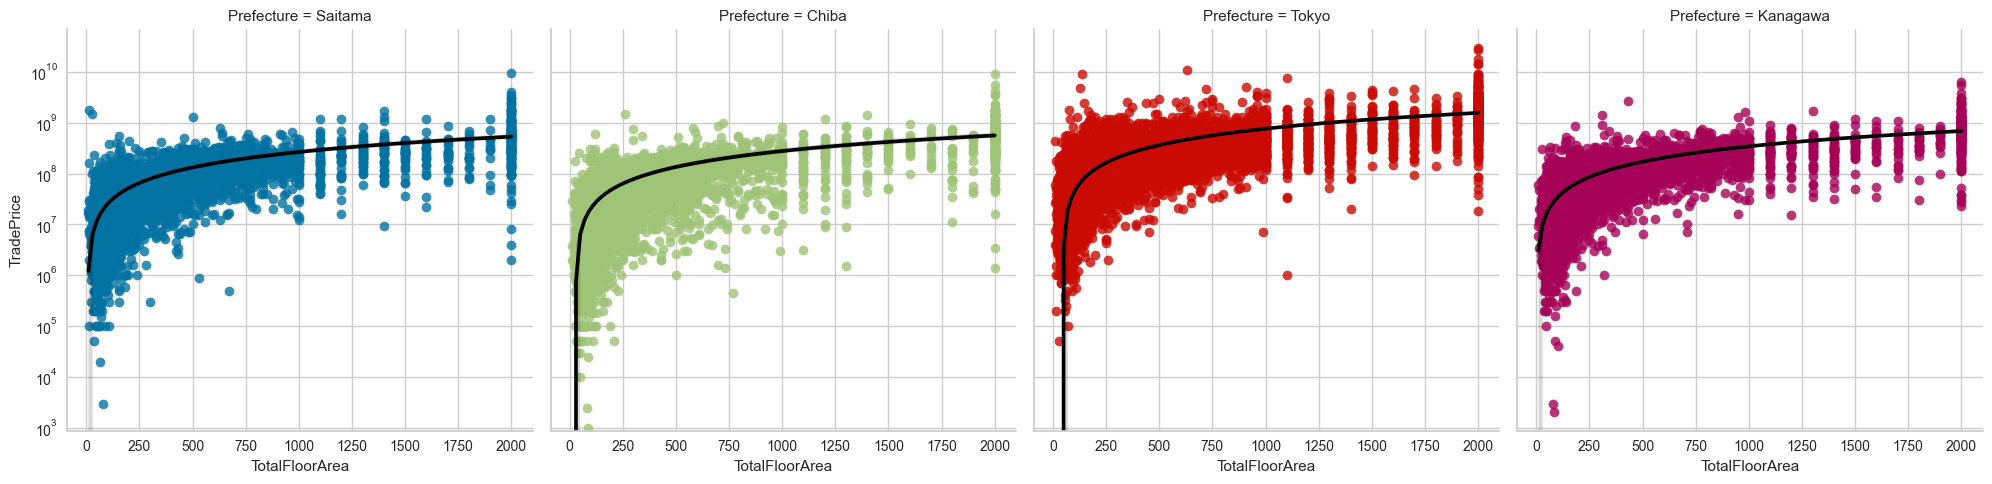

In [101]:
#FLOOR AREA vs TRADEPRICE
g = sns.lmplot(x="TotalFloorArea", y='TradePrice', data=data, hue='Prefecture', col="Prefecture", line_kws={'color': 'black', 'label': 'Best Fit Line'})
g.set(yscale="log")
plt.show()

##### 3.10.2 Building Age vs TradePrice

In [28]:
#add building age feature
data["BuildingAge"] = data["Year"] - data["BuildingYear"]
data = data.drop(['BuildingYear'], axis = 1)

#add mean time to nearest station
data["MeanTimeToNearestStation"] = (data["MaxTimeToNearestStation"] + data["MinTimeToNearestStation"]) / 2
data = data.drop(['MaxTimeToNearestStation', 'MinTimeToNearestStation'], axis = 1)

#add population density
data["PopDen"] = np.log(data["population"] / data["estimated_area"])
data = data.drop(['population', 'estimated_area'], axis = 1)

Best-Fit Line: -881355.932203386x + 38999999.99999995


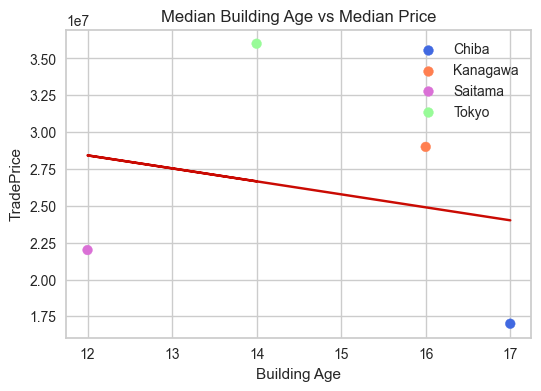

In [29]:
ageprice = pd.concat((data.groupby("Prefecture").median("BuildingAge")["BuildingAge"], data.groupby("Prefecture").median("TradePrice")["TradePrice"]), axis = 1)
bestfit = np.polyfit(ageprice["BuildingAge"], ageprice["TradePrice"], 1)
print("Best-Fit Line: {}x + {}".format(bestfit[0], bestfit[1]))
bestfit = bestfit[1] + bestfit[0] * ageprice["BuildingAge"]

plt.figure(figsize = (6,4))
plt.scatter(ageprice["BuildingAge"], ageprice["TradePrice"],c=colors)
for i in range(len(colors)):
    plt.scatter([], [], c=colors[i], label=ageprice.index[i])
plt.legend()
plt.plot(ageprice["BuildingAge"], bestfit, 'r')
plt.title("Median Building Age vs Median Price")
plt.xlabel("Building Age")
plt.ylabel("TradePrice")
plt.show()

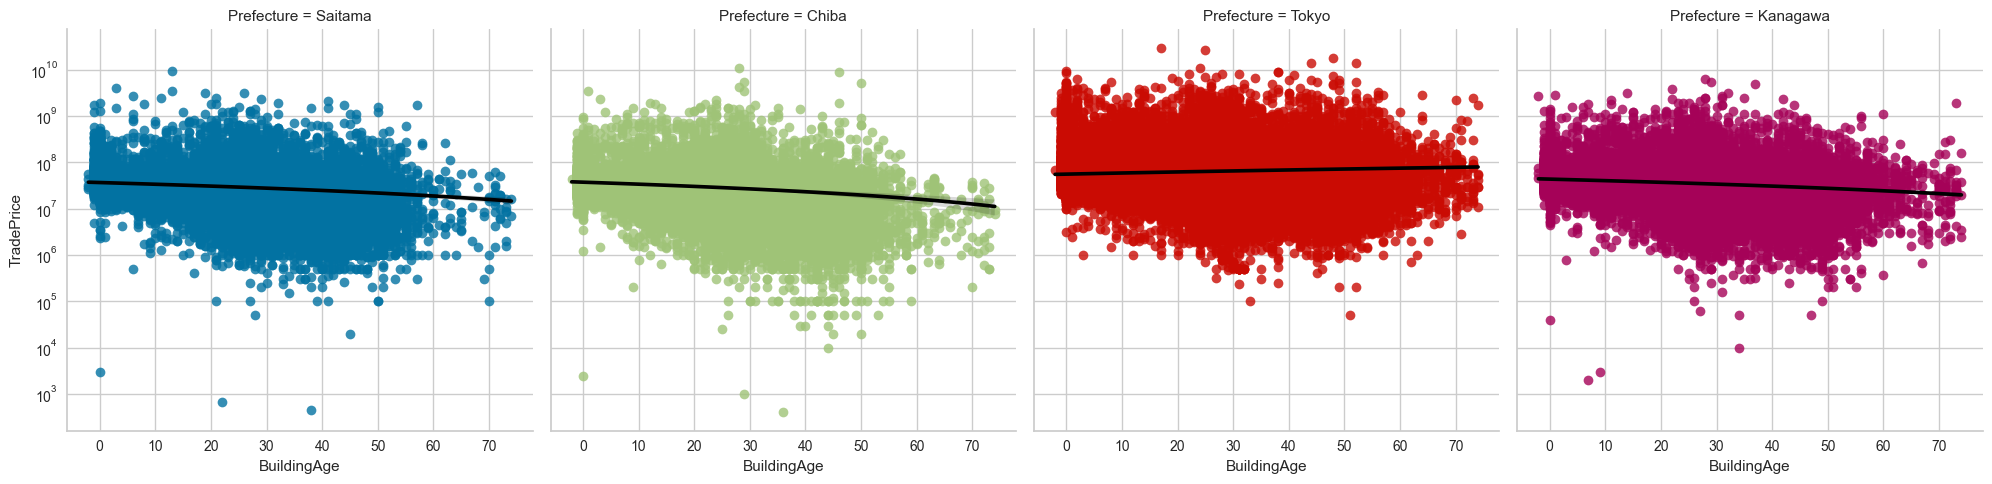

In [30]:
g = sns.lmplot(x="BuildingAge", y="TradePrice", data=data, hue='Prefecture', col="Prefecture", line_kws={'color': 'black', 'label': 'Best Fit Line'})
g.set(yscale="log")
plt.show()

##### 3.10.3 Time to Nearest Station vs TradePrice

Best-Fit Line: -2105263.1578947376x + 53368421.05263159


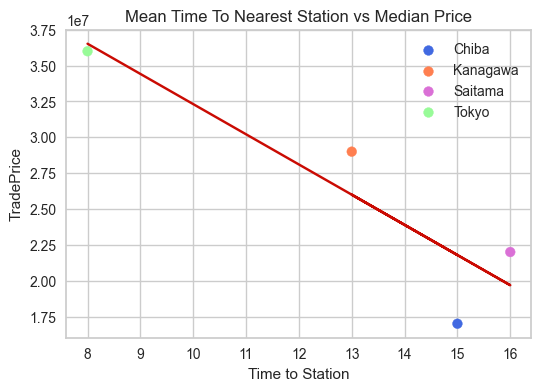

In [31]:
timeprice = pd.concat((data.groupby("Prefecture").median("MeanTimeToNearestStation")["MeanTimeToNearestStation"], data.groupby("Prefecture").median("TradePrice")["TradePrice"]), axis = 1)
bestfit = np.polyfit(timeprice["MeanTimeToNearestStation"], timeprice["TradePrice"], 1)
print("Best-Fit Line: {}x + {}".format(bestfit[0], bestfit[1]))
bestfit = bestfit[1] + bestfit[0] * timeprice["MeanTimeToNearestStation"]

plt.figure(figsize = (6,4))
plt.scatter(timeprice["MeanTimeToNearestStation"], timeprice["TradePrice"],c=colors)
for i in range(len(colors)):
    plt.scatter([], [], c=colors[i], label=ageprice.index[i])
plt.legend()
plt.plot(timeprice["MeanTimeToNearestStation"], bestfit, 'r')
plt.title("Mean Time To Nearest Station vs Median Price")
plt.xlabel("Time to Station")
plt.ylabel("TradePrice")
plt.show()

##### 3.10.4 Population Density vs TradePrice

Best-Fit Line: 11446164.881762186x + -64472912.724360734


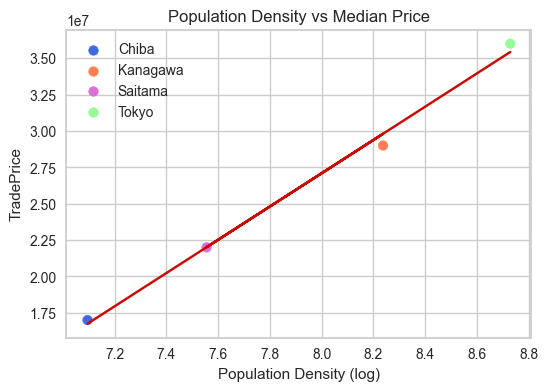

In [32]:
denprice = pd.concat((data.groupby("Prefecture").mean("PopDen")["PopDen"], data.groupby("Prefecture").median("TradePrice")["TradePrice"]), axis = 1)
bestfit = np.polyfit(denprice["PopDen"], denprice["TradePrice"], 1)
print("Best-Fit Line: {}x + {}".format(bestfit[0], bestfit[1]))
bestfit = bestfit[1] + bestfit[0] * denprice["PopDen"]

plt.figure(figsize = (6,4))
plt.scatter(denprice["PopDen"], denprice["TradePrice"],c=colors)
for i in range(len(colors)):
    plt.scatter([], [], c=colors[i], label=ageprice.index[i])
plt.legend()
plt.plot(denprice["PopDen"], bestfit, 'r')
plt.title("Population Density vs Median Price")
plt.xlabel("Population Density (log)")
plt.ylabel("TradePrice")
plt.show()

### 4. Data Cleaning Part 2 (Multicollinearity)

In [33]:
#manually set dummy columns for "Use"
data = data.dropna(subset="Use")

data['Use_House'] = np.where(data['Use'].str.contains('Hous'), 1, 0)
data['Use_Factory'] = np.where(data['Use'].str.contains('Factory'), 1, 0)
data['Use_Office'] = np.where(data['Use'].str.contains('Office'), 1, 0)
data['Use_Other'] = np.where(data['Use'].str.contains('Other'), 1, 0)
data['Use_Shop'] = np.where(data['Use'].str.contains('Shop'), 1, 0)
data['Use_Warehouse'] = np.where(data['Use'].str.contains('Warehouse'), 1, 0)

In [34]:
# columns to be dropped
drop_col = ["No", "MunicipalityCode", 
            "Period", "Remarks", "UnitPrice",
            "PricePerTsubo", "Year", "TimeToNearestStation"]

#columns with over 100 unique categorical values
over_100 = list(data.describe(include = 'object').columns[data.describe(include = 'object').loc["unique", :] > 100])

#new DataFrame
drop_col = drop_col + over_100
data2 = data.drop(drop_col, axis = 1)

In [35]:
corr = data2.corr()
top = abs(corr["TradePrice"]).sort_values(ascending = False)[0:6].index

corr["TradePrice"].loc[top[1:]]

TotalFloorArea                 0.520606
TotalFloorAreaIsGreaterFlag    0.450847
Area                           0.299813
AreaIsGreaterFlag              0.222618
Breadth                        0.218090
Name: TradePrice, dtype: float64

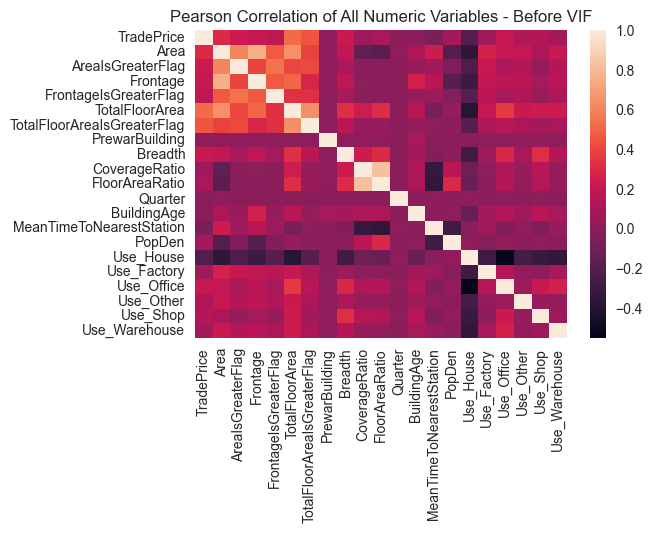

In [36]:
plt.figure(figsize = (6,4))
sns.heatmap(corr)
plt.title("Pearson Correlation of All Numeric Variables - Before VIF")
plt.show()

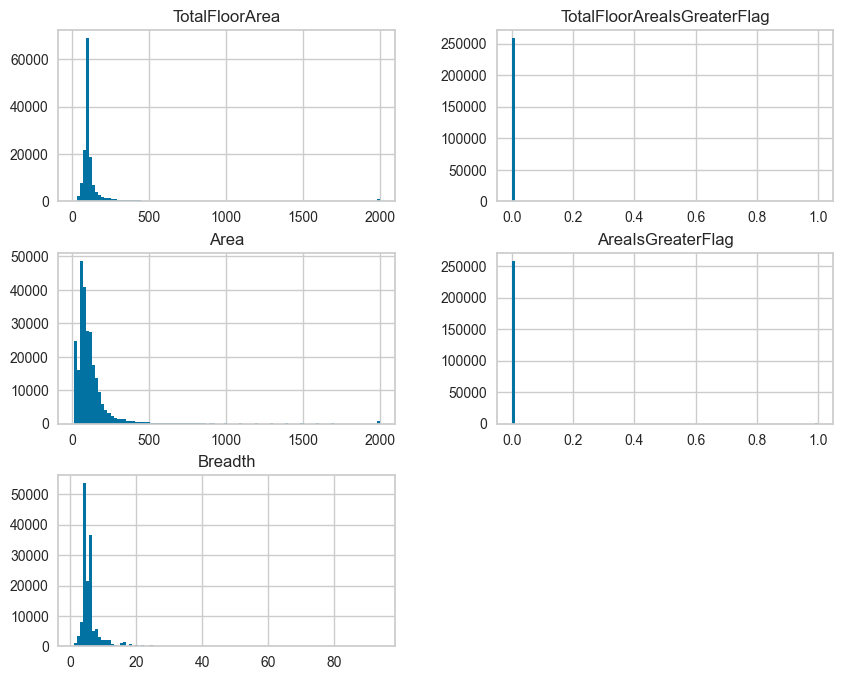

In [37]:
data2.loc[:,top[1:]].hist(figsize = (10,8), bins = 100)
plt.show()

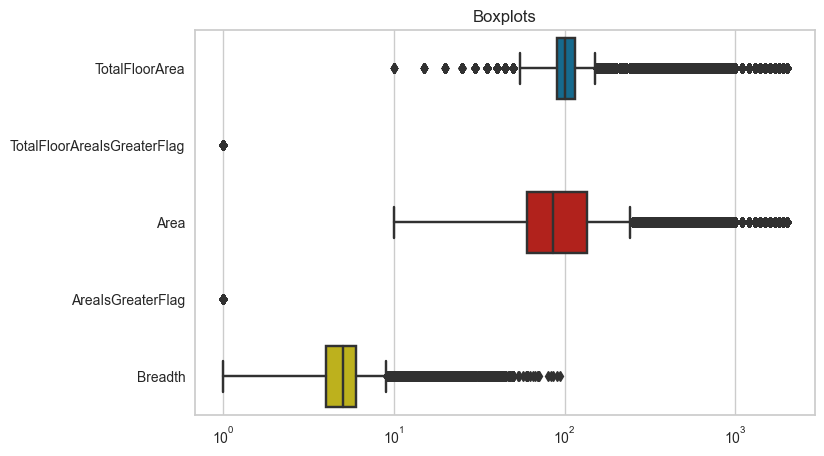

In [38]:
plt.figure(figsize = (8,5))
sns.boxplot(data = data2.loc[:,top[1:]], orient="h")
plt.title("Boxplots")
plt.xscale('log')
plt.show()

In [39]:
#set variables
y = data2["TradePrice"]
X = data2.drop(["TradePrice"], axis = 1)

#preprocessing - one hot encoding
cols_with_num = list(X.select_dtypes(include=[np.number]).columns)
cols_with_str = list(X.select_dtypes(exclude=[np.number]).columns)

X = pd.get_dummies(X, columns = cols_with_str)
cols_with_str = [i for i in list(X.columns) if i not in cols_with_num]

#drop nan values
Xy = pd.concat([X, y], axis = 1)
Xy = Xy.dropna()
y = Xy["TradePrice"]
X = Xy.drop(["TradePrice"], axis = 1)
Xcols = X.columns

In [40]:
#preprocessing - scaling
ss = StandardScaler()
X = ss.fit_transform(X)
X = pd.DataFrame(X, columns = Xcols) 

In [41]:
#handle multicollinearity using VIF

col_list = cols_with_num.copy()
check = 10

while (True):
    vif = pd.DataFrame() 
    vif["Feature"] = col_list
    vif["VIF"] = [variance_inflation_factor(X.loc[:, col_list].values, i) for i in range(len(col_list))] 
    check = max(vif["VIF"])
    
    if (check > 5):
        drop_idx = vif["VIF"].idxmax()
        curr = len(cols_with_num) - len(col_list)
        print("Drop Iter {}: {}; VIF: {}".format(curr, col_list[drop_idx], max(vif["VIF"])))
        col_list.pop(drop_idx)
    else:
    #     drop_idx = vif["VIF"].index[vif["VIF"].apply(np.isnan)][0]
    #     print("Drop Iter {}: {}; VIR: {}".format(curr + 1, col_list[drop_idx], "NaN"))
    #     col_list.pop(drop_idx)
    #     vif = pd.DataFrame() 
    #     vif["Feature"] = col_list
    #     vif["VIF"] = [variance_inflation_factor(X.loc[:, col_list].values, i) for i in range(len(col_list))] 
        
        break
        
col_list2 = col_list + cols_with_str

In [42]:
X = X.loc[:, col_list2]
vif

Feature       VIF
0                          Area  4.420399
1             AreaIsGreaterFlag  1.855665
2                      Frontage  2.431883
3                TotalFloorArea  3.383835
4   TotalFloorAreaIsGreaterFlag  1.843552
5                PrewarBuilding  1.010660
6                       Breadth  1.273334
7                 CoverageRatio  3.133957
8                FloorAreaRatio  3.628268
9                       Quarter  1.000367
10                  BuildingAge  1.186333
11     MeanTimeToNearestStation  1.131207
12                       PopDen  1.168744
13                    Use_House  1.955113
14                  Use_Factory  1.175989
15                   Use_Office  1.594669
16                    Use_Other  1.130359
17                     Use_Shop  1.344488
18                Use_Warehouse  1.202006

In [43]:
#get new correlations
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
data_scaled = pd.concat([y, X], axis = 1)

corr= data_scaled.corr()
top = abs(corr["TradePrice"]).sort_values(ascending = False)[0:6].index

corr["TradePrice"].loc[top[1:]]

TotalFloorArea                 0.519501
TotalFloorAreaIsGreaterFlag    0.453631
Area                           0.297337
Structure_SRC                  0.278296
FloorAreaRatio                 0.260619
Name: TradePrice, dtype: float64

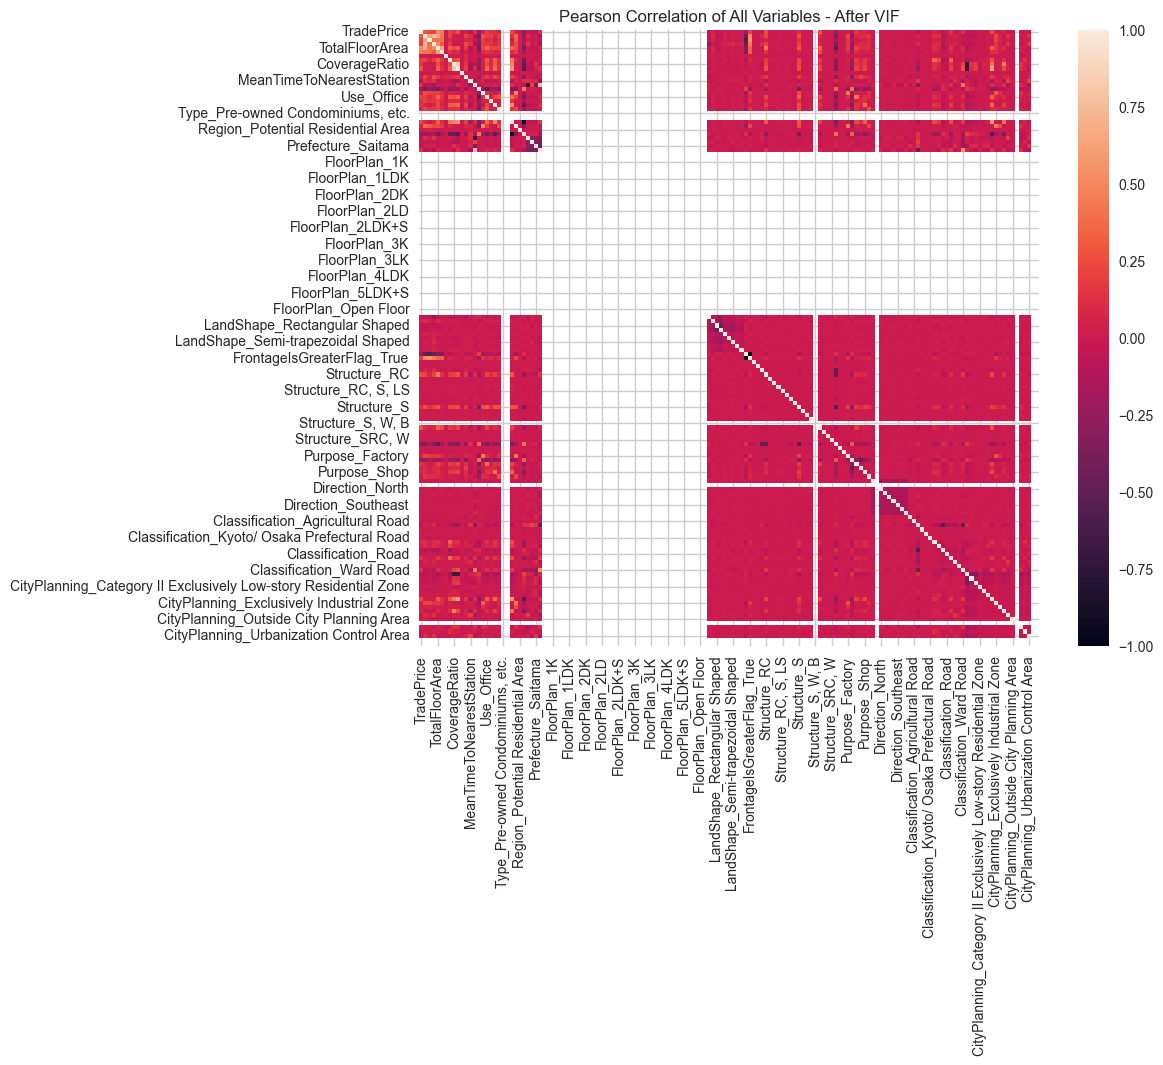

In [44]:
plt.figure(figsize=(10,8))
sns.heatmap(corr)
plt.title("Pearson Correlation of All Variables - After VIF")
plt.show()

In [45]:
#drop columns with NaN correlation
drop_nan = corr.iloc[:,0].index[corr.iloc[:,0].apply(np.isnan)]
X = X.drop(drop_nan, axis = 1)
X.shape

(132166, 103)

In [46]:
#get new correlations
X.reset_index(drop=True, inplace=True)
data_scaled2 = pd.concat([y, X], axis = 1)

corr2 = data_scaled2.corr()
top2 = abs(corr2["TradePrice"]).sort_values(ascending = False)[0:11].index

corr2["TradePrice"].loc[top2[1:]]

TotalFloorArea                  0.519501
TotalFloorAreaIsGreaterFlag     0.453631
Area                            0.297337
Structure_SRC                   0.278296
FloorAreaRatio                  0.260619
Structure_W                    -0.245364
Region_Residential Area        -0.242348
CityPlanning_Commercial Zone    0.242010
Structure_RC                    0.235066
Region_Commercial Area          0.231330
Name: TradePrice, dtype: float64

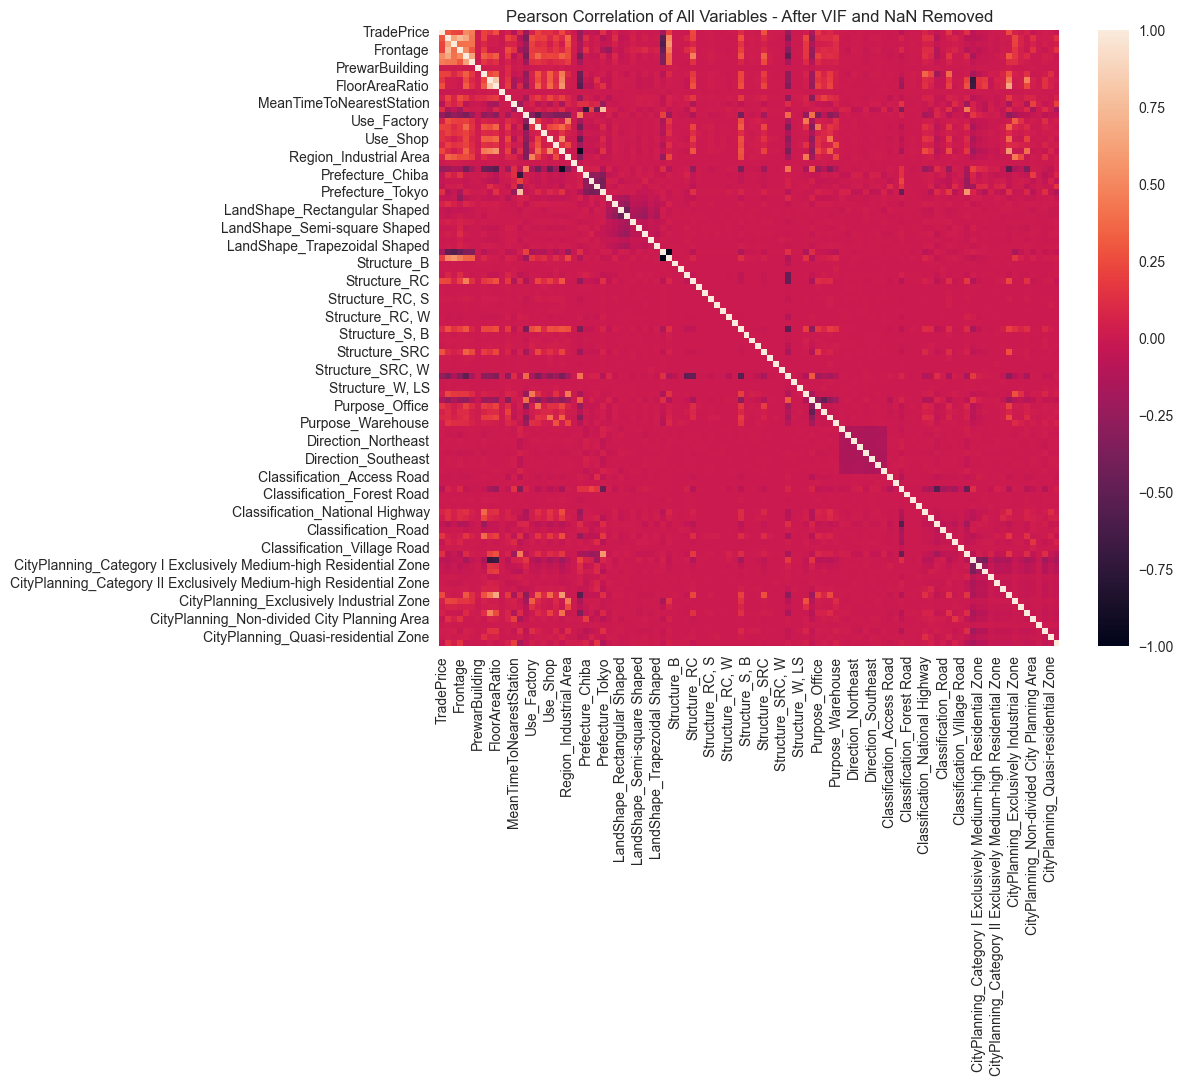

In [47]:
plt.figure(figsize=(10,8))
sns.heatmap(corr2)
plt.title("Pearson Correlation of All Variables - After VIF and NaN Removed")
plt.show()

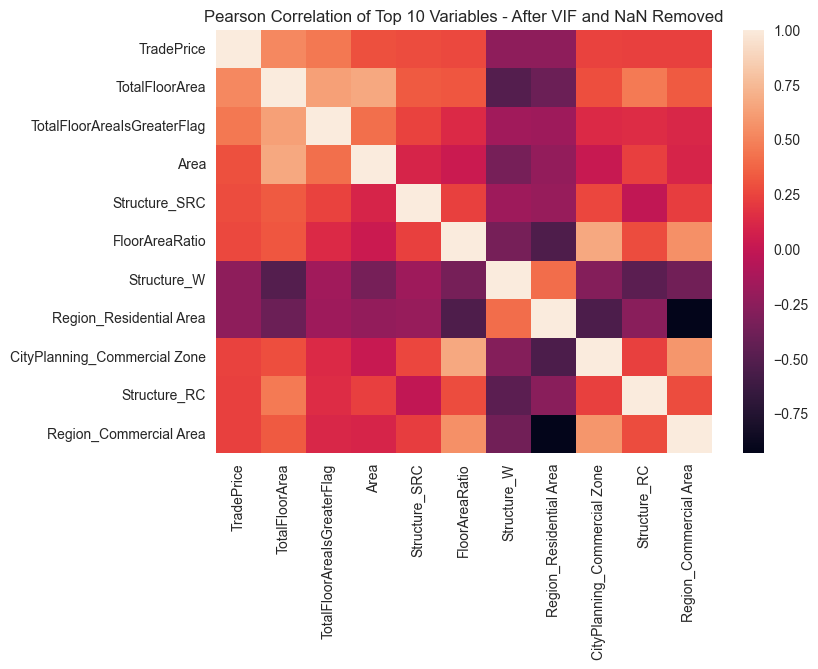

In [48]:
sns.heatmap(data_scaled2.loc[:, top2].corr())
plt.title("Pearson Correlation of Top 10 Variables - After VIF and NaN Removed")
plt.show()

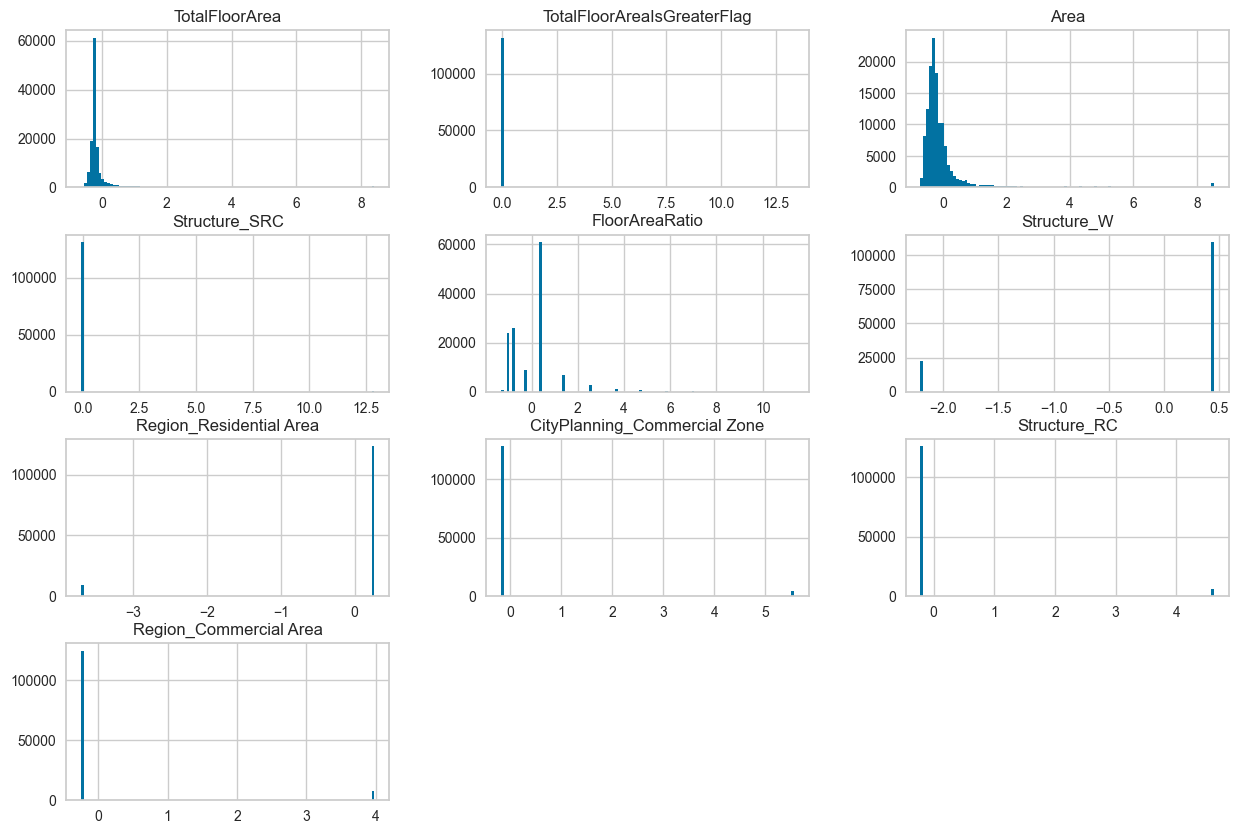

In [49]:
data_scaled2.loc[:,top2[1:]].hist(figsize = (15,10), bins = 100)
plt.show()

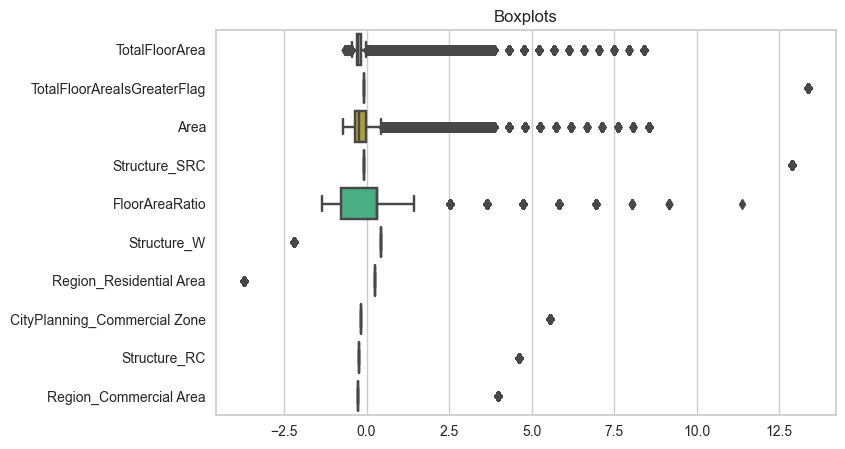

In [50]:
plt.figure(figsize = (8,5))
sns.boxplot(data = data_scaled2.loc[:,top2[1:]], orient="h")
plt.title("Boxplots")
plt.show()

### 5. Running Models

#### 5.1 Model with log-scaled TradePrice

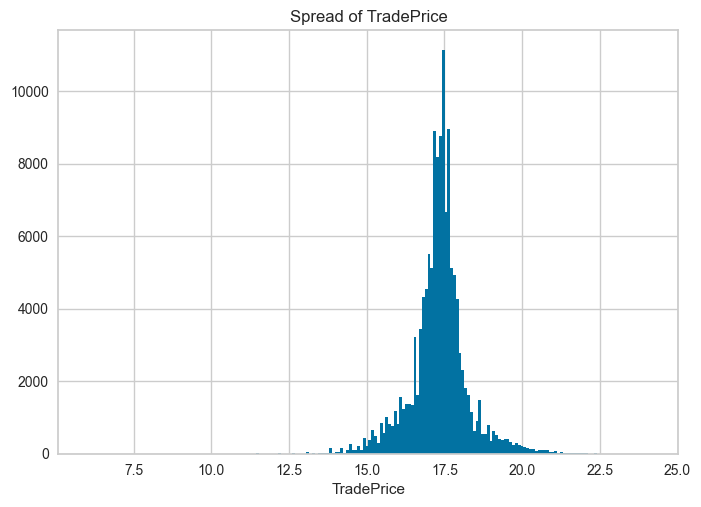

In [51]:
# Prepare target
data_scaled3 = data_scaled2.copy()
data_scaled3["TradePrice"] = np.log(data_scaled2["TradePrice"])
df = data_scaled3

data_scaled3['TradePrice'].hist(bins = 200)
plt.title("Spread of TradePrice")
plt.xlabel("TradePrice")
plt.show()

In [52]:
#Initialize Pycaret
#set target variable
target = "TradePrice"
randseed = 1010101010

# default settings:  0.8 split train vs validation
#                    10-fold StratifiedKFold cross validation                  

exp_reg = setup(data = df, target = target, n_jobs = -1,
                categorical_features = [], train_size = 0.8,
                normalize = False, session_id = randseed)

In [53]:
best_models = compare_models(sort="MSE")
model_dfs = pull()
model_dfs

Initiated  . . . . . . . . . . . . . . . . . .              19:22:32
Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library

Model           MAE           MSE  \
catboost               CatBoost Regressor  2.917000e-01  1.836000e-01   
xgboost         Extreme Gradient Boosting  2.996000e-01  1.939000e-01   
lightgbm  Light Gradient Boosting Machine  3.017000e-01  1.947000e-01   
et                  Extra Trees Regressor  2.972000e-01  1.983000e-01   
rf                Random Forest Regressor  2.986000e-01  1.992000e-01   
gbr           Gradient Boosting Regressor  3.234000e-01  2.204000e-01   
ridge                    Ridge Regression  3.769000e-01  2.856000e-01   
br                         Bayesian Ridge  3.769000e-01  2.856000e-01   
huber                     Huber Regressor  3.735000e-01  2.987000e-01   
omp           Orthogonal Matching Pursuit  3.979000e-01  3.169000e-01   
knn                 K Neighbors Regressor  4.400000e-01  4.039000e-01   
dt                Decision Tree Regressor  4.252000e-01  4.046000e-01   
par          Passive Aggressive Regressor  5.607000e-01  6.156000e-01   
ada                    AdaBoost Regressor  7.226000e-01  8.001000e-01   
en                            Elastic Net  6.307000e-01  8.834000e-01   
lasso                    Lasso Regression  6.318000e-01  8.882000e-01   
llar         Lasso Least Angle Regression  6.318000e-01  8.882000e-01   
dummy                     Dummy Regressor  6.318000e-01  8.882000e-01   
lr                      Linear Regression  1.069000e+00  4.745151e+04   
lar                Least Angle Regression  1.810704e+09  3.565142e+21   

                  RMSE            R2   RMSLE          MAPE  TT (Sec)  
catboost  4.284000e-01  7.933000e-01  0.0246  1.720000e-02     3.945  
xgboost   4.403000e-01  7.816000e-01  0.0253  1.770000e-02     4.293  
lightgbm  4.412000e-01  7.808000e-01  0.0253  1.780000e-02     0.765  
et        4.452000e-01  7.768000e-01  0.0255  1.750000e-02    19.331  
rf        4.463000e-01  7.757000e-01  0.0256  1.760000e-02    16.783  
gbr       4.694000e-01  7.518000e-01  0.0268  1.900000e-02     3.602  
ridge     5.344000e-01  6.784000e-01  0.0303  2.210000e-02     0.534  
br        5.344000e-01  6.784000e-01  0.0303  2.210000e-02     1.019  
huber     5.464000e-01  6.636000e-01  0.0329  2.200000e-02     3.767  
omp       5.629000e-01  6.432000e-01  0.0318  2.330000e-02     0.544  
knn       6.355000e-01  5.452000e-01  0.0358  2.590000e-02     1.733  
dt        6.360000e-01  5.443000e-01  0.0367  2.500000e-02     0.779  
par       7.820000e-01  3.065000e-01  0.0446  3.250000e-02     0.609  
ada       8.908000e-01  9.820000e-02  0.0504  4.160000e-02     6.269  
en        9.398000e-01  5.300000e-03  0.0518  3.680000e-02     0.542  
lasso     9.424000e-01 -1.000000e-04  0.0520  3.690000e-02     0.542  
llar      9.424000e-01 -1.000000e-04  0.0520  3.690000e-02     0.538  
dummy     9.424000e-01 -1.000000e-04  0.0520  3.690000e-02     0.502  
lr        7.158650e+01 -5.303138e+04  0.0385  6.570000e-02     1.260  
lar       2.404584e+10 -4.083142e+21  4.8487  1.042769e+08     0.538

#### 5.2 Model Evaluation

##### 5.2.1 Train CV Score

In [54]:
models_list = ["catboost","xgboost","lightgbm","rf","et","gbr","knn","ridge"]

In [83]:
for i in models_list:
    var_name1 = "{}".format(i)
    print(var_name1)
    locals()[var_name1] = create_model(i,verbose=True)

catboost


Initiated  . . . . . . . . . . . . . . . . . .              19:47:08
Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

xgboost


Initiated  . . . . . . . . . . . . . . . . . .              19:47:56
Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

lightgbm


Initiated  . . . . . . . . . . . . . . . . . .              19:48:45
Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

rf


Initiated  . . . . . . . . . . . . . . . . . .              19:48:55
Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

et


Initiated  . . . . . . . . . . . . . . . . . .              19:52:01
Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

gbr


Initiated  . . . . . . . . . . . . . . . . . .              19:56:36
Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

knn


Initiated  . . . . . . . . . . . . . . . . . .              19:57:36
Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

ridge


Initiated  . . . . . . . . . . . . . . . . . .              19:57:54
Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

##### 5.2.2 Test Score

In [56]:
# predict on hold-out test set
for i in models_list:
    print(i)
    predict_model(eval(i),verbose=True)

catboost


xgboost


lightgbm


rf


et


gbr


knn


ridge


##### 5.2.3 Feature Importance

catboost


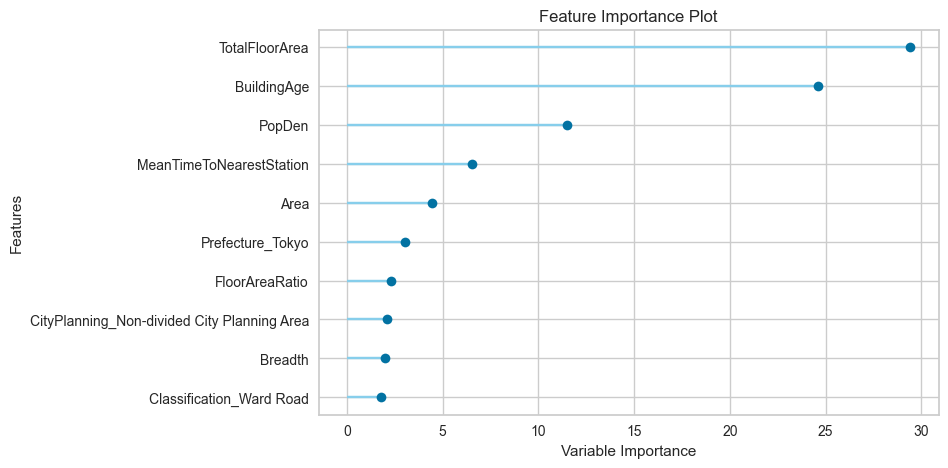

xgboost


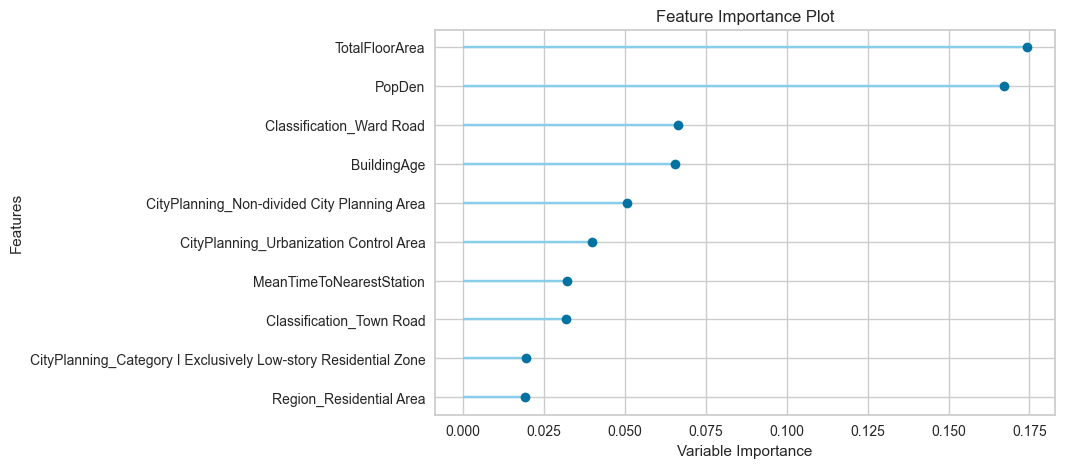

lightgbm


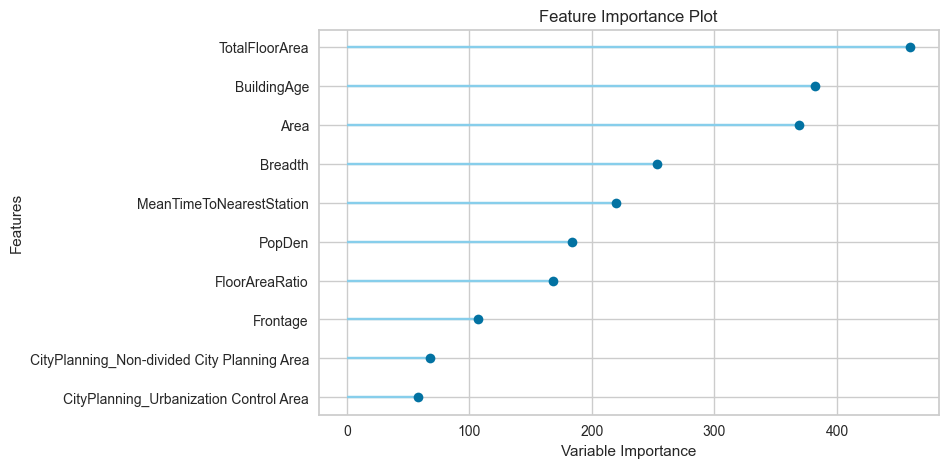

rf


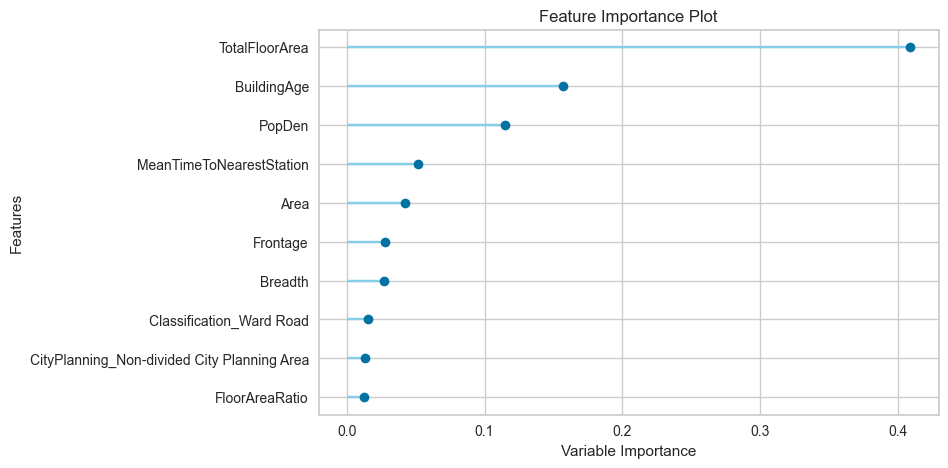

et


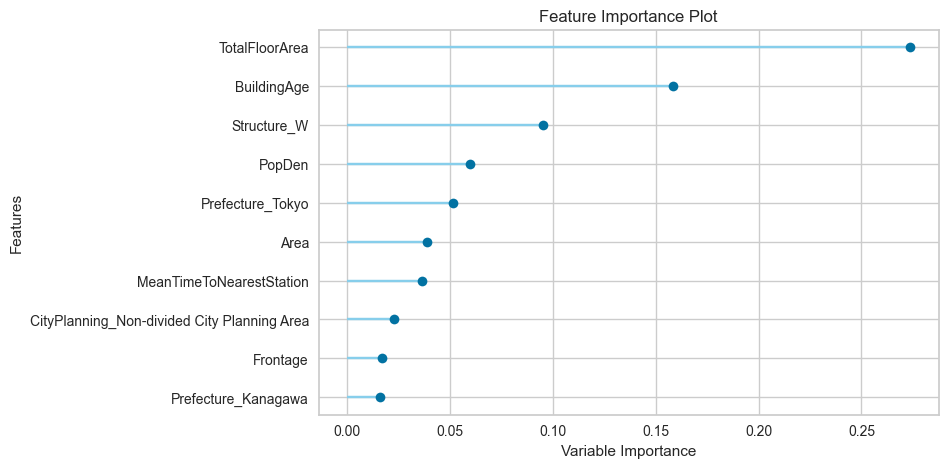

gbr


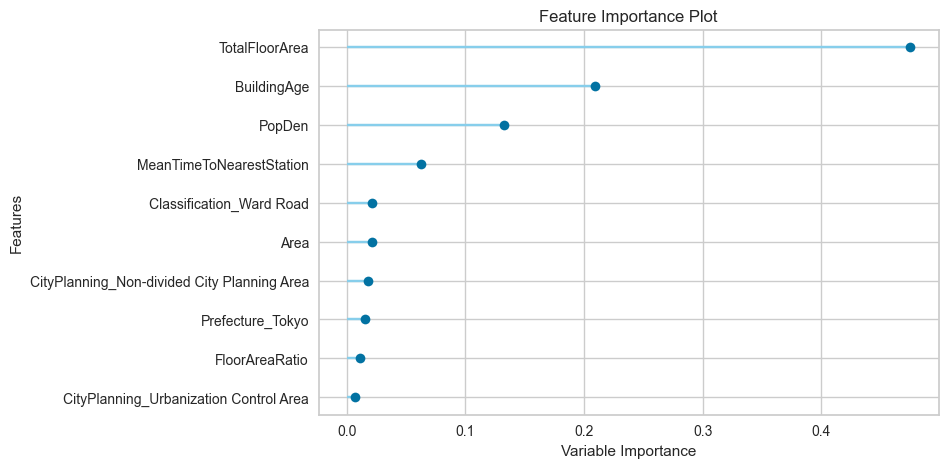

knn
ridge


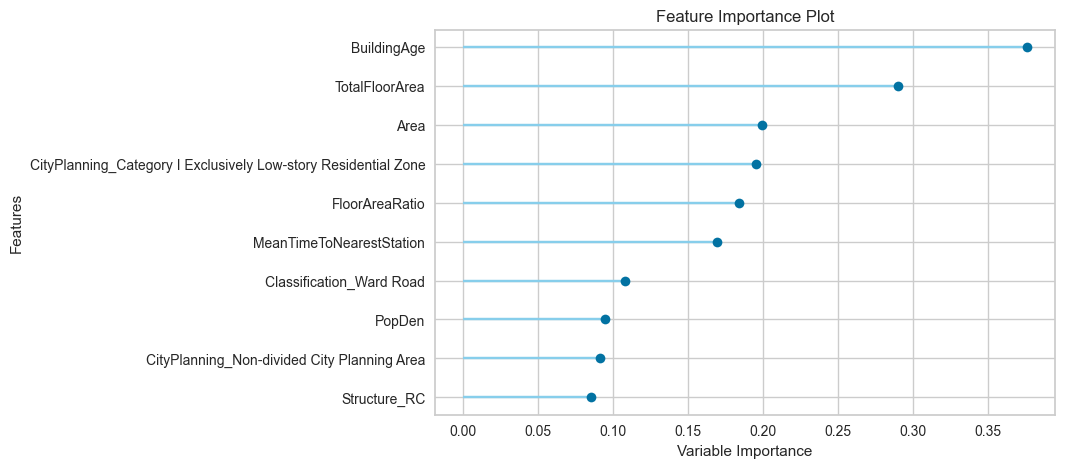

In [57]:
for i in models_list:
    try:
        print(i)
        plot_model(eval(i),plot='feature')
    except:
        pass

##### 5.2.4 Residuals

catboost


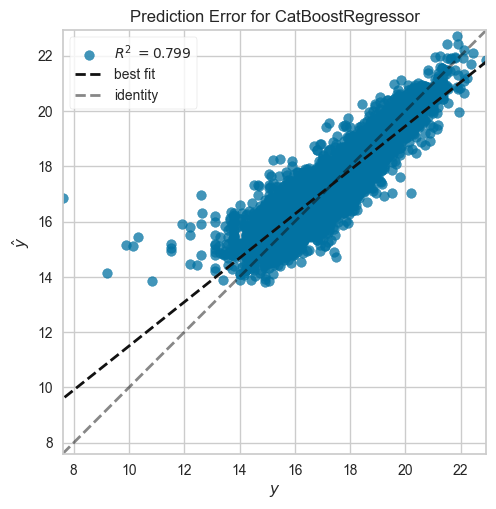

xgboost


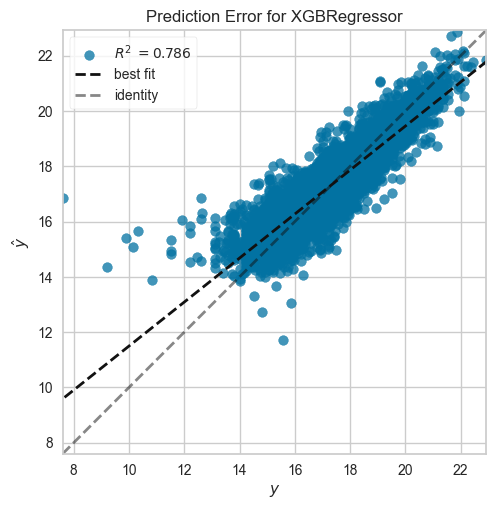

lightgbm


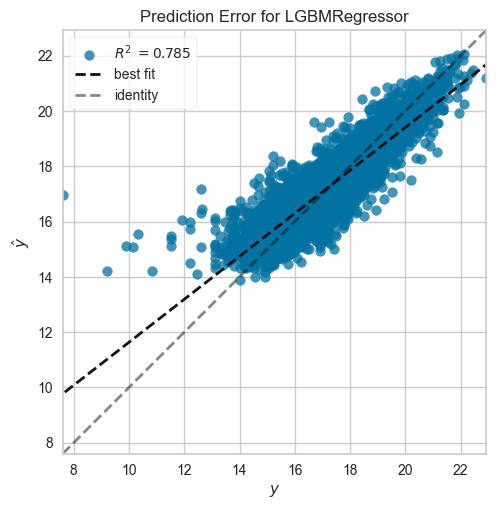

rf


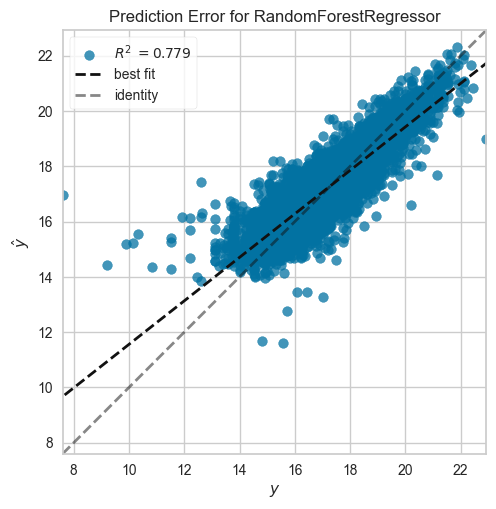

et


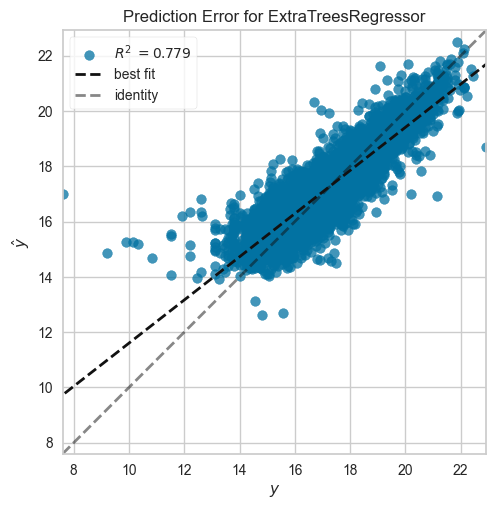

gbr


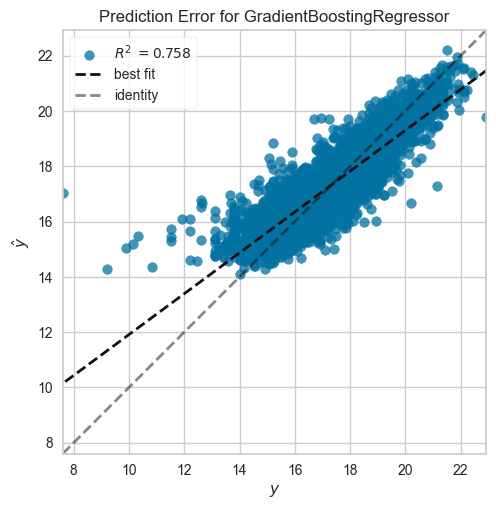

knn


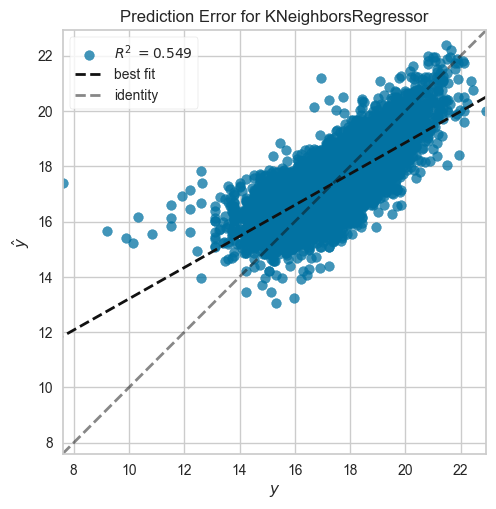

ridge


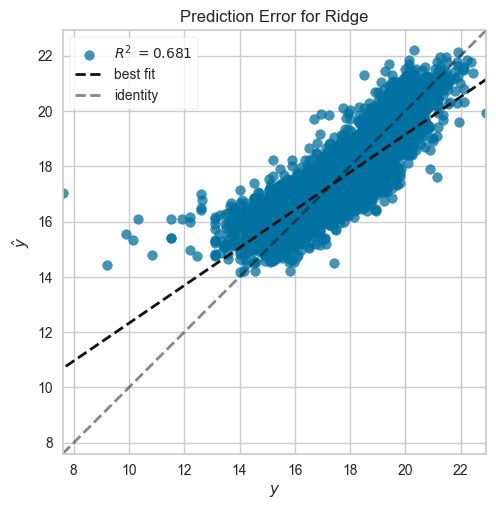

In [58]:
for i in models_list:
    try:
        print(i)
        plot_model(eval(i),plot='error')
    except:
        pass

#### 5.3 Compare Returns of Each Model

##### 5.3.1 Absolute Returns (in Millions of Yen)

In [165]:
# define function to generate random float between 0.8 and 1.2
def random_mul():
    return round(random.uniform(0.8, 1.21), 1)

In [166]:
price_list = get_config('test_transformed')
price_list["TradePrice"] = np.exp(price_list["TradePrice"])

thresh = [1,1.05,1.1,1.15,1.2]

In [167]:
results = []
for k in range(50):
    price_list["ListPrice"] = price_list["TradePrice"].apply(lambda x:x * random_mul())
    abs_returns = pd.DataFrame(columns = ['Model','No Threshold','5% Threshold','10% Threshold','15% Threshold','20% Threshold'])

    for i in models_list:
        profit_list = [i]
        temp = predict_model(eval(i),verbose=False)
        temp["TradePrice"] = np.exp(temp["TradePrice"])
        temp["PredPrice"] = np.exp(temp["prediction_label"])
        temp["ListPrice"] = price_list["ListPrice"]
        for j in thresh:
            temp['Profit'] = np.where(temp['PredPrice'] > (temp['ListPrice']*j), temp['TradePrice'] - temp['ListPrice'], np.nan)
            profit_list.append((temp["Profit"].sum())/1000000)
        abs_returns.loc[len(abs_returns)] = profit_list
    results.append(abs_returns)

results_df = pd.concat(results).groupby('Model').mean().reset_index()
results_df["Average Return"] = results_df.iloc[:, 1:6].mean(axis=1)
results_df.sort_values('Average Return',ascending=False,inplace=True)

In [168]:
results_df

Model  No Threshold  5% Threshold  10% Threshold  15% Threshold  \
0  catboost  23767.270337  22972.492866   21700.896198   19804.678601   
7   xgboost  23570.875124  22873.878338   21491.872030   19850.574127   
1        et  24385.416264  23218.986937   21448.461170   19048.744847   
5        rf  24559.911685  22881.695341   21099.203524   19018.245737   
4  lightgbm  23112.651966  21952.175263   20335.900612   18554.677299   
2       gbr  20472.795924  19507.927160   18105.250831   16446.774736   
6     ridge  17273.318299  16721.836188   16024.030964   15173.445251   
3       knn  14982.063295  14416.643004   13772.948947   12643.155441   

   20% Threshold  Average Return  
0   17921.939146    21233.455430  
7   17737.806205    21105.001165  
1   16819.558076    20984.233459  
5   16910.933569    20893.997971  
4   16512.686962    20093.618420  
2   14930.836172    17892.716965  
6   14096.264445    15857.779029  
3   11674.564577    13497.875053

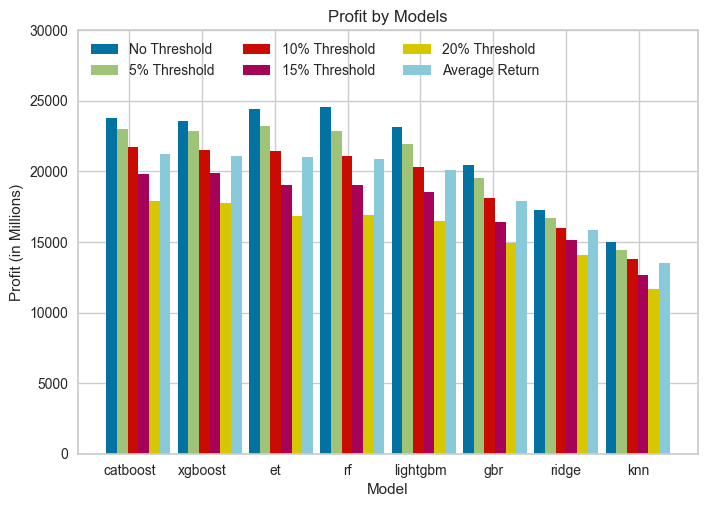

In [169]:
x = np.arange(8) 

width = 0.15
group_offset = 0.02
multiplier = 0

pdf = results_df.drop("Model",axis=1)
fig, ax = plt.subplots()

for attribute, measurement in pdf.items():
    offset = width * multiplier + group_offset * np.floor(multiplier/len(pdf))
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Profit (in Millions)')
ax.set_xlabel('Model')
ax.set_title('Profit by Models')
ax.set_xticks(x + 0.1 +  width + group_offset * np.arange(len(results_df.loc[:,'Model'])))
ax.set_xticklabels(results_df.loc[:,'Model'])
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 30000)

plt.show()

##### 5.3.2 Percentage Returns

In [170]:
results = []
for k in range(50):
    price_list["ListPrice"] = price_list["TradePrice"].apply(lambda x:x * random_mul())
    pc_returns = pd.DataFrame(columns = ['Model','No Threshold','5% Threshold','10% Threshold','15% Threshold','20% Threshold'])

    for i in models_list:
        profit_list = [i]
        temp = predict_model(eval(i),verbose=False)
        temp["TradePrice"] = np.exp(temp["TradePrice"])
        temp["PredPrice"] = np.exp(temp["prediction_label"])
        temp["ListPrice"] = price_list["ListPrice"]
        for j in thresh:
            temp = temp[temp['PredPrice'] > (temp['ListPrice']*j)]
            temp['Profit'] = temp['TradePrice'] - temp['ListPrice']
            profit_list.append((temp["Profit"].sum())/(temp["ListPrice"].sum())*100)
        pc_returns.loc[len(pc_returns)] = profit_list
    results.append(pc_returns)

results_df = pd.concat(results).groupby('Model').mean().reset_index()
results_df["Average % Return"] =  results_df.iloc[:, 1:6].mean(axis=1)
results_df.sort_values('Average % Return',ascending=False,inplace=True)

In [171]:
results_df

Model  No Threshold  5% Threshold  10% Threshold  15% Threshold  \
1        et      4.722285      5.335166       5.761746       6.092745   
5        rf      4.731889      5.186829       5.657567       5.984021   
4  lightgbm      4.530321      4.991401       5.444440       5.863372   
0  catboost      4.409865      4.940194       5.473891       5.848460   
7   xgboost      4.305221      4.786725       5.333941       5.733325   
2       gbr      4.319715      4.735732       5.132888       5.407604   
6     ridge      3.333620      3.639606       3.979618       4.230150   
3       knn      3.305882      3.581342       3.836310       3.978462   

   20% Threshold  Average % Return  
1       6.357745          5.653937  
5       6.249885          5.562038  
4       6.215626          5.409032  
0       6.293205          5.393123  
7       5.988300          5.229502  
2       5.753542          5.069896  
6       4.440718          3.924743  
3       4.170598          3.774519

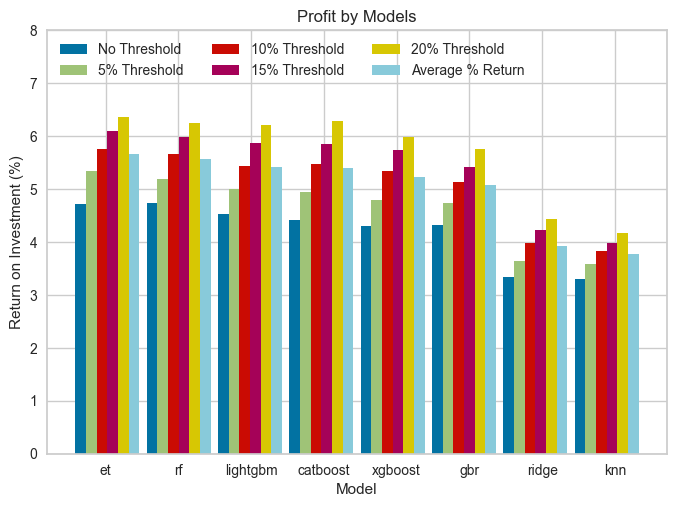

In [172]:
x = np.arange(8) 

width = 0.15
group_offset = 0.02
multiplier = 0

pdf = results_df.drop("Model",axis=1)
fig, ax = plt.subplots()

for attribute, measurement in pdf.items():
    offset = width * multiplier + group_offset * np.floor(multiplier/len(pdf))
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Return on Investment (%)')
ax.set_xlabel('Model')
ax.set_title('Profit by Models')
ax.set_xticks(x + 0.2 +  width + group_offset * np.arange(len(results_df.loc[:,'Model'])))
ax.set_xticklabels(results_df.loc[:,'Model'])
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 8)

plt.show()